Notebook Setup

In [ ]:
!pip install torch torchvision torchaudio -q
!pip install torch-geometric -q
!pip install dgl -q  # generic DGL (CPU/GPU autodetect)
!pip install torchmetrics==1.4.0.post0 scikit-learn pandas numpy tqdm geopy haversine -q

In [ ]:
# ============================================================
# Imports
# ============================================================
import pandas as pd
import numpy as np
import ast
from collections import defaultdict
import itertools

import torch
from torch import nn
import torch.nn.functional as F

from tqdm import tqdm
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import pairwise_distances

import wandb

In [ ]:
# ============================================================
# DEVICE SETUP
# ============================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# ============================================================
# wandb setup
# ============================================================

wandb.login()

wandb: Currently logged in as: leeij (leeisabella) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
# Tracking over time
K = 20  # top-K to evaluate
all_results = []

Data Loading and Preprocessing

In [ ]:
# ============================================================
# Load CSVs into train, val, and test sets
# ============================================================

def load_reviews_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    def try_literal(x):
        # Safely convert stringified lists/dicts; leave others alone
        try:
            return ast.literal_eval(str(x))
        except Exception:
            return x

    df = df.applymap(try_literal)
    return df

train_df = load_reviews_csv("train_reviews.csv")
val_df = load_reviews_csv("val_reviews.csv")
test_df = load_reviews_csv("test_reviews.csv")

print("train:", train_df.shape)
print("val:",   val_df.shape)
print("test:",  test_df.shape)

/tmp/ipython-input-2503511894.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
/tmp/ipython-input-2503511894.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(try_literal)
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:2: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:3: SyntaxWarning: invalid decimal literal
<unknown>:7: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1:

train: (278388, 37)
val: (34798, 37)
test: (34799, 37)


Feature Building

In [ ]:
# ============================================================
# Normalize 'price' column into integer price levels for HGT
# ============================================================

def normalize_price(x):
    # Handle NaN
    if pd.isna(x):
        return 0  # unknown price

    # If it's a number (float or int)
    if isinstance(x, (int, float)):
        return int(x)

    # If it's a string: attempt numeric conversion
    if isinstance(x, str):
        x = x.strip()

        # Like "$$", "$$$", etc. → map to length
        if all(c == '$' for c in x):
            return len(x)

        # If string represents a number, convert
        if x.isdigit():
            return int(x)

        # Otherwise fallback
        return 0

    # Anything else
    return 0

# Apply to train, val, test (to keep consistency)
for df in [train_df, val_df, test_df]:
    df["price"] = df["price"].apply(normalize_price)

In [ ]:
# ============================================================
# Build global ID mappings and add user/item columns
# ============================================================
all_users = pd.concat(
    [train_df["user_id"], val_df["user_id"], test_df["user_id"]],
    ignore_index=True
)
all_items = pd.concat(
    [train_df["gmap_id"], val_df["gmap_id"], test_df["gmap_id"]],
    ignore_index=True
)

user2idx = {u: idx for idx, u in enumerate(all_users.unique())}
item2idx = {i: idx for idx, i in enumerate(all_items.unique())}

num_users = len(user2idx)
num_items = len(item2idx)
print("num_users:", num_users, "num_items:", num_items)

for df in [train_df, val_df, test_df]:
    df["u"] = df["user_id"].map(user2idx)
    df["i"] = df["gmap_id"].map(item2idx)

# Train-only view for all feature construction (avoid leakage)
full_df_train = train_df.copy()

num_users: 25841 num_items: 2923


In [ ]:
# ============================================================
# Normalized Feature Builder
# ============================================================

# ============================================================
# 1. Ensure category is always a list of items
# ============================================================
for df in [train_df, val_df, test_df]:
    df["category"] = df["category"].apply(lambda x: x if isinstance(x, list) else [])

# TRAIN-ONLY METADATA
df_train = full_df_train.copy()


# ============================================================
# 2. Geographical features (latitude, longitude)
# ============================================================
df_train["latitude"]  = pd.to_numeric(df_train["latitude"], errors="coerce")
df_train["longitude"] = pd.to_numeric(df_train["longitude"], errors="coerce")

item_geo = (
    df_train.groupby("i")[["latitude", "longitude"]]
    .mean()                           # average per item
    .reindex(range(num_items))        # ensure full coverage
    .fillna(0.0)
)

# Normalize geo features (z-score)
item_geo = (item_geo - item_geo.mean()) / (item_geo.std() + 1e-6)
item_geo = item_geo.fillna(0.0).astype("float32")


# ============================================================
# 3. Create Multi-Hot columns for categories
# ============================================================
from sklearn.preprocessing import MultiLabelBinarizer

cat_lists = df_train.groupby("i")["category"].apply(
    lambda x: x.iloc[0] if isinstance(x.iloc[0], list) else []
)

mlb = MultiLabelBinarizer()
cat_matrix = mlb.fit_transform(cat_lists)

item_cat = (
    pd.DataFrame(cat_matrix, columns=[f"cat_{c}" for c in mlb.classes_], index=cat_lists.index)
    .reindex(range(num_items), fill_value=0)
    .astype("float32")
)


# ============================================================
# 4. Create numeric stats (avg_rating, num_of_reviews)
# ============================================================

stats = (
    df_train.groupby("i")[["avg_rating", "num_of_reviews"]]
    .first()
    .reindex(range(num_items))
)

stats["avg_rating"]     = pd.to_numeric(stats["avg_rating"], errors="coerce").fillna(0)
stats["num_of_reviews"] = pd.to_numeric(stats["num_of_reviews"], errors="coerce").fillna(0)

# Normalize ratings: center around 3, scale by 2 → range ≈ [-1, +1]
stats["avg_rating"] = (stats["avg_rating"] - 3.0) / 2.0

# Normalize review counts: log transform for stability
stats["num_of_reviews"] = np.log1p(stats["num_of_reviews"])

# z-score normalize stats
stats = (stats - stats.mean()) / (stats.std() + 1e-6)
item_stats = stats.fillna(0).astype("float32")


# ============================================================
# 5. Misc features and tags
# ============================================================

misc_cols = [c for c in df_train.columns if c.startswith("MISC")]

# Extract vocabulary
misc_labels = set()
for col in misc_cols:
    for entry in df_train[col]:
        if isinstance(entry, list):
            misc_labels.update(entry)

misc_labels = sorted(misc_labels)
misc_label2idx = {tag: idx for idx, tag in enumerate(misc_labels)}

# Initialize (num_items, num_misc_labels)
item_misc_np = np.zeros((num_items, len(misc_labels)), dtype="float32")

# Fill MISC tags
for idx, row in df_train.iterrows():
    i = row["i"]
    if not (0 <= i < num_items):
        continue
    for col in misc_cols:
        tags = row[col]
        if isinstance(tags, list):
            for tag in tags:
                j = misc_label2idx.get(tag)
                if j is not None:
                    item_misc_np[i, j] = 1.0

item_misc = pd.DataFrame(item_misc_np, columns=[f"misc_{m}" for m in misc_labels])

# z-score normalize MISC features
# (optional: many models skip normalization for binary one-hot)
if item_misc.values.sum() > 0:
    item_misc = (item_misc - item_misc.mean()) / (item_misc.std() + 1e-6)
item_misc = item_misc.fillna(0).astype("float32")


# ============================================================
# 6. Combine ALL item features safely
# ============================================================
item_features_np = np.hstack([
    item_geo.values.astype("float32"),
    item_cat.values.astype("float32"),
    item_stats.values.astype("float32"),
    item_misc.values.astype("float32"),
])

# ============================================================
# 7. Final global normalization for stability
# ============================================================
item_features_np = (item_features_np - item_features_np.mean(axis=0)) / \
                   (item_features_np.std(axis=0) + 1e-6)

item_features_np = np.nan_to_num(item_features_np, nan=0.0, posinf=0.0, neginf=0.0)

item_features = torch.tensor(item_features_np, dtype=torch.float32)
print("Final item_features shape:", item_features.shape)


Final item_features shape: torch.Size([2923, 538])


In [ ]:
# ============================================================
# Train-only user features (home coord, count, avg rating) and normalize
# ============================================================

user_latlon = (
    df_train.groupby("u")[["latitude", "longitude"]]
    .mean()
    .reindex(range(num_users))
    .fillna(0.0)
)

# normalize latitude/longitude
user_latlon = (user_latlon - user_latlon.mean()) / (user_latlon.std() + 1e-6)
user_latlon = user_latlon.fillna(0)

user_review_counts = (
    df_train.groupby("u")["rating"]
    .count()
    .reindex(range(num_users))
    .fillna(0)
)

# log-normalize review counts
user_review_counts = np.log1p(user_review_counts)

# z-score normalize
user_review_counts = (user_review_counts - user_review_counts.mean()) / (user_review_counts.std() + 1e-6)

user_avg_rating = (
    df_train.groupby("u")["rating"]
    .mean()
    .reindex(range(num_users))
    .fillna(3.0)  # neutral rating
)

# normalize: center at 3, divide by 2
user_avg_rating = (user_avg_rating - 3.0) / 2.0

# z-score
user_avg_rating = (user_avg_rating - user_avg_rating.mean()) / (user_avg_rating.std() + 1e-6)

# combine
user_features_np = np.vstack([
    user_latlon["latitude"].values,
    user_latlon["longitude"].values,
    user_review_counts.values,
    user_avg_rating.values
]).T.astype("float32")

user_features_np = np.nan_to_num(user_features_np, nan=0.0, posinf=0.0, neginf=0.0)

user_features = torch.tensor(user_features_np, dtype=torch.float32)
print("Final user_features shape:", user_features.shape)

Final user_features shape: torch.Size([25841, 4])


Diagonstics - Make sure all features look right

In [ ]:
print("Any NaNs in item_features:", torch.isnan(item_features).any().item())
print("Any Infs in item_features:", torch.isinf(item_features).any().item())
print("Item feature max/min:", item_features.max(), item_features.min())

print("\nAny NaNs in user_features:", torch.isnan(user_features).any().item())
print("Any Infs in user_features:", torch.isinf(user_features).any().item())
print("User feature max/min:", user_features.max(), user_features.min())

Any NaNs in item_features: False
Any Infs in item_features: False
Item feature max/min: tensor(54.0580) tensor(-4.7510)

Any NaNs in user_features: False
Any Infs in user_features: False
User feature max/min: tensor(4.7317) tensor(-4.7366)


In [ ]:
print("GEO NaNs:",    np.isnan(item_geo.values).any())
print("CAT NaNs:",    np.isnan(item_cat.values).any())
print("STATS NaNs:",  np.isnan(item_stats.values).any())
print("MISC NaNs:",   np.isnan(item_misc.values).any())

GEO NaNs: False
CAT NaNs: False
STATS NaNs: False
MISC NaNs: False


In [ ]:
print("GEO shape:", item_geo.shape)
print("CAT shape:", item_cat.shape)
print("STATS shape:", item_stats.shape)
print("MISC shape:", item_misc.shape)
print("Expected num_items:", num_items)

GEO shape: (2923, 2)
CAT shape: (2923, 415)
STATS shape: (2923, 2)
MISC shape: (2923, 119)
Expected num_items: 2923


In [ ]:
bad_item_mask = torch.isnan(item_features).any(dim=1) | torch.isinf(item_features).any(dim=1)
bad_items = bad_item_mask.nonzero(as_tuple=True)[0]

print("Bad item count:", len(bad_items))
print("Bad item indices:", bad_items[:20])

Bad item count: 0
Bad item indices: tensor([], dtype=torch.int64)


Model 1: LightGCN

In [ ]:
# ============================================================
# Train graph (user–item bipartite, symmetric) & helpers
# ============================================================

u_train = torch.tensor(train_df["u"].values, dtype=torch.long)
i_train = torch.tensor(train_df["i"].values + num_users, dtype=torch.long)

# make edges bidirectional
edge_index = torch.stack([
    torch.cat([u_train, i_train]),
    torch.cat([i_train, u_train]),
], dim=0)

num_nodes = num_users + num_items
print("edge_index shape:", edge_index.shape, "num_nodes:", num_nodes)

# Positive items per user for TRAIN (for negative sampling)
user_pos_train = full_df_train.groupby("u")["i"].apply(set).to_dict()

def sample_negative(u: int, k: int = 1):
    """Random negative items for user u, using TRAIN positives only."""
    positives = user_pos_train.get(int(u), set())
    negatives = []
    while len(negatives) < k:
        j = np.random.randint(0, num_items)
        if j not in positives:
            negatives.append(j)
    return negatives


edge_index shape: torch.Size([2, 556776]) num_nodes: 28764


In [ ]:
# ============================================================
# Move data tensors to prevent device mismatch
# ============================================================

# Move data tensors to correct device
edge_index = edge_index.to(device)
item_features = item_features.to(device)
user_features = user_features.to(device)

In [ ]:
# ============================================================
# LightGCN Implementation
# ============================================================

class LightGCN(nn.Module):
    def __init__(self, num_users, num_items, user_feat_dim, item_feat_dim,
                 dim=64, n_layers=3):
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.dim = dim
        self.n_layers = n_layers

        # Learnable embeddings
        self.user_emb = nn.Embedding(num_users, dim)
        self.item_emb = nn.Embedding(num_items, dim)

        # Feature projections (all trained)
        self.user_feat_proj = nn.Linear(user_feat_dim, dim, bias=False)
        self.item_feat_proj = nn.Linear(item_feat_dim, dim, bias=False)

        nn.init.xavier_uniform_(self.user_emb.weight)
        nn.init.xavier_uniform_(self.item_emb.weight)

    def propagate(self, x, edge_index):
        row, col = edge_index
        deg = torch.bincount(row, minlength=x.size(0)).float()
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float("inf")] = 0

        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        msg = x[col] * norm.unsqueeze(1)

        out = torch.zeros_like(x)
        out.index_add_(0, row, msg)
        return out

    def forward(self, edge_index):
        # Move embeddings + features to correct device
        user_x = self.user_emb.weight + self.user_feat_proj(user_features)
        item_x = self.item_emb.weight + self.item_feat_proj(item_features)

        x = torch.cat([user_x, item_x], dim=0)
        all_layers = [x]

        for _ in range(self.n_layers):
            x = self.propagate(x, edge_index)
            all_layers.append(x)

        x_final = torch.stack(all_layers, dim=1).mean(dim=1)

        user_gcn = x_final[:self.num_users]
        item_gcn = x_final[self.num_users:]
        return user_gcn, item_gcn

    def predict(self, u, i, user_gcn, item_gcn):
        return (user_gcn[u] * item_gcn[i]).sum(dim=-1)

In [ ]:
# ============================================================
# BPR loss & training utilities
# ============================================================

from tqdm.auto import tqdm
import wandb

def bpr_loss(model, edge_index, batch_users, batch_pos_items):
    user_gcn, item_gcn = model(edge_index)

    neg_items = torch.tensor(
        [sample_negative(int(u))[0] for u in batch_users],
        dtype=torch.long,
        device=device,
    )

    pos_scores = model.predict(batch_users, batch_pos_items, user_gcn, item_gcn)
    neg_scores = model.predict(batch_users, neg_items, user_gcn, item_gcn)

    return -torch.log(torch.sigmoid(pos_scores - neg_scores)).mean()

def train_bpr_model(model, edge_index, train_df, epochs=10, batch_size=1024, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_users = torch.tensor(train_df["u"].values, dtype=torch.long, device=device)
    train_items = torch.tensor(train_df["i"].values, dtype=torch.long, device=device)

    epoch_losses, batch_losses = [], []

    for epoch in range(epochs):
        perm = torch.randperm(len(train_users), device=device)
        epoch_loss = 0.0

        pbar = tqdm(perm.split(batch_size), desc=f"LightGCN Epoch {epoch+1}/{epochs}")

        for step, idx in enumerate(pbar):
            batch_u = train_users[idx]
            batch_i = train_items[idx]

            loss = bpr_loss(model, edge_index, batch_u, batch_i)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            bl = loss.item()
            batch_losses.append(bl)
            epoch_loss += bl

            pbar.set_postfix({"batch_loss": f"{bl:.4f}", "epoch_loss": f"{epoch_loss:.4f}"})

        epoch_losses.append(epoch_loss)
        print(f"[LightGCN] Epoch {epoch+1}: total_loss={epoch_loss:.4f}")

    return model, epoch_losses, batch_losses


In [ ]:
# ============================================================
# Final LightGCN Hyperparameters
# ============================================================

lightgcn_layers = 4
lightgcn_dim = 32
lightgcn_lr = 5e-4
lightgcn_batch_size = 2048

In [ ]:
# ============================================================
# Train baseline LightGCN
# ============================================================

wandb.init(
    project="restaurant-recsys",
    name="LightGCN-normalized",
    config={
        "model": "LightGCN",
        "embedding_dim": lightgcn_dim,
        "layers": lightgcn_layers,
        "epochs": 10,
        "batch_size": lightgcn_batch_size,
        "learning_rate": lightgcn_lr,
        "num_users": num_users,
        "num_items": num_items,
        "item_feature_dim": item_features.shape[1],
        "user_feature_dim": user_features.shape[1],
    }
)

lgcn = LightGCN(
    num_users=num_users,
    num_items=num_items,
    user_feat_dim=user_features.shape[1],
    item_feat_dim=item_features.shape[1],
    dim=lightgcn_dim,
    n_layers=lightgcn_layers
).to(device)

lgcn, epoch_losses, batch_losses = train_bpr_model(
    lgcn,
    edge_index,
    train_df,
    epochs=10,
    batch_size=lightgcn_batch_size,
    lr=lightgcn_lr
)

wandb.finish()

LightGCN Epoch 1/10:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=59.9138


LightGCN Epoch 2/10:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=50.1222


LightGCN Epoch 3/10:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=45.7400


LightGCN Epoch 4/10:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=42.9526


LightGCN Epoch 5/10:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=40.9532


LightGCN Epoch 6/10:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCN] Epoch 6: total_loss=39.3632


LightGCN Epoch 7/10:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCN] Epoch 7: total_loss=37.8692


LightGCN Epoch 8/10:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCN] Epoch 8: total_loss=36.7944


LightGCN Epoch 9/10:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCN] Epoch 9: total_loss=35.6116


LightGCN Epoch 10/10:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCN] Epoch 10: total_loss=34.5767


In [ ]:
# ============================================================
# Evaluation metrics and generic evaluator functionality
# ============================================================

# Recall
def recall_at_k(target, ranked_list, k):
    return int(target in ranked_list[:k])

# NDCG
def ndcg_at_k(target, ranked_list, k):
    if target in ranked_list[:k]:
        rank = ranked_list.index(target) + 1
        return 1.0 / np.log2(rank + 1)
    return 0.0

# MRR
def mrr_metric(target, ranked_list):
    if target in ranked_list:
        return 1.0 / (ranked_list.index(target) + 1)
    return 0.0

# Evaluation (for validation sets)
def evaluate_lgcn_like(model, edge_index, eval_df, k=20):
    model.eval()
    with torch.no_grad():
        user_gcn, item_gcn = model(edge_index)

    recalls, ndcgs, mrrs = [], [], []

    for row in tqdm(eval_df.itertuples(), total=len(eval_df)):
        u = int(row.u)
        true_i = int(row.i)

        scores = (user_gcn[u] * item_gcn).sum(dim=1).cpu().numpy()
        ranked_items = list(np.argsort(-scores))

        recalls.append(recall_at_k(true_i, ranked_items, k))
        ndcgs.append(ndcg_at_k(true_i, ranked_items, k))
        mrrs.append(mrr_metric(true_i, ranked_items))

    return {
        "Recall@{}".format(k): float(np.mean(recalls)),
        "NDCG@{}".format(k): float(np.mean(ndcgs)),
        "MRR": float(np.mean(mrrs)),
    }

print("Baseline LightGCN on validation:")
metrics = evaluate_lgcn_like(lgcn, edge_index, val_df, k=20)
metrics


Baseline LightGCN on validation:


  0%|          | 0/34798 [00:00<?, ?it/s]

{'Recall@20': 0.06483131214437611,
 'NDCG@20': 0.02532107406712505,
 'MRR': 0.01922808032439703}

In [ ]:
# 1) LightGCN baseline
metrics_lgcn_test = evaluate_lgcn_like(lgcn, edge_index, test_df, k=K)
all_results.append({"Model": "LightGCN", "Split": "test", **metrics_lgcn_test})

  0%|          | 0/34799 [00:00<?, ?it/s]

LightGCN Hyperparameter Tuning

In [ ]:
# ============================================================
# LightGCN Hyperparameter Tuning (Using Grid Search)
# ============================================================

import pandas as pd
import itertools

# Search spaces (tune as needed)
dim_grid        = [32, 64, 128]        # embedding sizes
layers_grid     = [3, 4]            # number of propagation layers
batch_grid      = [1024, 2048, 4096]   # batch sizes
lr_grid         = [1e-3, 5e-4]         # learning rates
epochs_val      = 5                   # or 20 if you prefer longer training

results_lgcn = []

for dim_val, layers_val, batch_val, lr_val in itertools.product(
        dim_grid, layers_grid, batch_grid, lr_grid):

    print(f"\n=== Training LightGCN (dim={dim_val}, layers={layers_val}, "
          f"batch={batch_val}, lr={lr_val}) ===")

    # Initialize a fresh LightGCN model
    model = LightGCN(
        num_users=num_users,
        num_items=num_items,
        user_feat_dim=user_features.shape[1],
        item_feat_dim=item_features.shape[1],
        dim=dim_val,
        n_layers=layers_val
    ).to(device)

    # Train model
    model, epoch_losses, batch_losses = train_bpr_model(
        model,
        edge_index,
        train_df,
        epochs=epochs_val,
        batch_size=batch_val,
        lr=lr_val
    )

    # Evaluate on validation set
    metrics_val = evaluate_lgcn_like(model, edge_index, val_df, k=20)

    # Store results
    results_lgcn.append({
        "dim": dim_val,
        "layers": layers_val,
        "batch_size": batch_val,
        "lr": lr_val,
        "Recall@20_val": metrics_val["Recall@20"],
        "NDCG@20_val": metrics_val["NDCG@20"],
        "MRR_val": metrics_val["MRR"],
    })

# Build and display results table
lightgcn_tuning_df = pd.DataFrame(results_lgcn)
display(lightgcn_tuning_df.sort_values("Recall@20_val", ascending=False))


=== Training LightGCN (dim=32, layers=3, batch=1024, lr=0.001) ===


LightGCN Epoch 1/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=94.1754


LightGCN Epoch 2/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=74.2688


LightGCN Epoch 3/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=65.6186


LightGCN Epoch 4/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=58.8745


LightGCN Epoch 5/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=54.8941


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=32, layers=3, batch=1024, lr=0.0005) ===


LightGCN Epoch 1/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=101.9507


LightGCN Epoch 2/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=84.4901


LightGCN Epoch 3/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=76.8420


LightGCN Epoch 4/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=71.8516


LightGCN Epoch 5/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=67.8630


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=32, layers=3, batch=2048, lr=0.001) ===


LightGCN Epoch 1/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=50.7220


LightGCN Epoch 2/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=41.0204


LightGCN Epoch 3/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=36.3070


LightGCN Epoch 4/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=33.4549


LightGCN Epoch 5/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=31.1332


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=32, layers=3, batch=2048, lr=0.0005) ===


LightGCN Epoch 1/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=55.2295


LightGCN Epoch 2/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=45.9411


LightGCN Epoch 3/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=41.7558


LightGCN Epoch 4/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=39.1751


LightGCN Epoch 5/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=37.1943


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=32, layers=3, batch=4096, lr=0.001) ===


LightGCN Epoch 1/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=26.6523


LightGCN Epoch 2/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=22.2057


LightGCN Epoch 3/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=19.7181


LightGCN Epoch 4/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=18.4271


LightGCN Epoch 5/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=17.3078


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=32, layers=3, batch=4096, lr=0.0005) ===


LightGCN Epoch 1/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=28.6407


LightGCN Epoch 2/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=24.8268


LightGCN Epoch 3/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=22.8435


LightGCN Epoch 4/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=21.3978


LightGCN Epoch 5/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=20.2196


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=32, layers=4, batch=1024, lr=0.001) ===


LightGCN Epoch 1/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=96.8470


LightGCN Epoch 2/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=78.6848


LightGCN Epoch 3/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=71.4677


LightGCN Epoch 4/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=65.5038


LightGCN Epoch 5/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=60.3907


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=32, layers=4, batch=1024, lr=0.0005) ===


LightGCN Epoch 1/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=103.3452


LightGCN Epoch 2/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=86.9503


LightGCN Epoch 3/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=80.3163


LightGCN Epoch 4/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=75.7948


LightGCN Epoch 5/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=71.5562


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=32, layers=4, batch=2048, lr=0.001) ===


LightGCN Epoch 1/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=52.9705


LightGCN Epoch 2/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=43.4828


LightGCN Epoch 3/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=39.0730


LightGCN Epoch 4/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=36.3604


LightGCN Epoch 5/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=34.2967


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=32, layers=4, batch=2048, lr=0.0005) ===


LightGCN Epoch 1/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=56.5530


LightGCN Epoch 2/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=47.5207


LightGCN Epoch 3/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=43.5834


LightGCN Epoch 4/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=40.8442


LightGCN Epoch 5/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=39.2192


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=32, layers=4, batch=4096, lr=0.001) ===


LightGCN Epoch 1/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=27.8395


LightGCN Epoch 2/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=23.2344


LightGCN Epoch 3/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=21.0523


LightGCN Epoch 4/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=19.5661


LightGCN Epoch 5/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=18.6123


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=32, layers=4, batch=4096, lr=0.0005) ===


LightGCN Epoch 1/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=29.2560


LightGCN Epoch 2/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=25.5369


LightGCN Epoch 3/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=23.8491


LightGCN Epoch 4/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=22.5403


LightGCN Epoch 5/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=21.5040


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=64, layers=3, batch=1024, lr=0.001) ===


LightGCN Epoch 1/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=86.8422


LightGCN Epoch 2/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=65.1237


LightGCN Epoch 3/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=55.3140


LightGCN Epoch 4/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=48.6453


LightGCN Epoch 5/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=43.8489


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=64, layers=3, batch=1024, lr=0.0005) ===


LightGCN Epoch 1/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=94.9159


LightGCN Epoch 2/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=77.0204


LightGCN Epoch 3/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=68.4071


LightGCN Epoch 4/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=62.0869


LightGCN Epoch 5/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=57.0059


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=64, layers=3, batch=2048, lr=0.001) ===


LightGCN Epoch 1/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=46.7454


LightGCN Epoch 2/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=36.3996


LightGCN Epoch 3/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=31.4804


LightGCN Epoch 4/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=28.0997


LightGCN Epoch 5/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=25.3498


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=64, layers=3, batch=2048, lr=0.0005) ===


LightGCN Epoch 1/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=52.5650


LightGCN Epoch 2/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=42.6469


LightGCN Epoch 3/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=38.2830


LightGCN Epoch 4/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=35.3248


LightGCN Epoch 5/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=32.8100


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=64, layers=3, batch=4096, lr=0.001) ===


LightGCN Epoch 1/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=25.3348


LightGCN Epoch 2/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=20.2665


LightGCN Epoch 3/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=17.9069


LightGCN Epoch 4/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=16.2082


LightGCN Epoch 5/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=14.8854


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=64, layers=3, batch=4096, lr=0.0005) ===


LightGCN Epoch 1/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=27.9828


LightGCN Epoch 2/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=23.2727


LightGCN Epoch 3/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=21.0445


LightGCN Epoch 4/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=19.6006


LightGCN Epoch 5/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=18.4515


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=64, layers=4, batch=1024, lr=0.001) ===


LightGCN Epoch 1/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=89.9858


LightGCN Epoch 2/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=70.4090


LightGCN Epoch 3/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=60.7211


LightGCN Epoch 4/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=53.5983


LightGCN Epoch 5/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=48.8409


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=64, layers=4, batch=1024, lr=0.0005) ===


LightGCN Epoch 1/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=99.9699


LightGCN Epoch 2/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=81.5845


LightGCN Epoch 3/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=73.7777


LightGCN Epoch 4/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=67.6640


LightGCN Epoch 5/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=62.4612


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=64, layers=4, batch=2048, lr=0.001) ===


LightGCN Epoch 1/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=47.8751


LightGCN Epoch 2/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=38.5096


LightGCN Epoch 3/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=33.8973


LightGCN Epoch 4/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=30.9279


LightGCN Epoch 5/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=28.3462


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=64, layers=4, batch=2048, lr=0.0005) ===


LightGCN Epoch 1/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=51.3771


LightGCN Epoch 2/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=42.5579


LightGCN Epoch 3/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=38.7082


LightGCN Epoch 4/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=35.9902


LightGCN Epoch 5/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=34.2180


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=64, layers=4, batch=4096, lr=0.001) ===


LightGCN Epoch 1/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=25.5886


LightGCN Epoch 2/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=21.1845


LightGCN Epoch 3/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=18.7933


LightGCN Epoch 4/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=17.3890


LightGCN Epoch 5/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=16.2722


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=64, layers=4, batch=4096, lr=0.0005) ===


LightGCN Epoch 1/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=27.7879


LightGCN Epoch 2/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=23.5923


LightGCN Epoch 3/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=21.6163


LightGCN Epoch 4/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=20.4562


LightGCN Epoch 5/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=19.2145


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=128, layers=3, batch=1024, lr=0.001) ===


LightGCN Epoch 1/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=83.6983


LightGCN Epoch 2/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=57.3224


LightGCN Epoch 3/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=46.6770


LightGCN Epoch 4/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=39.6656


LightGCN Epoch 5/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=35.1753


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=128, layers=3, batch=1024, lr=0.0005) ===


LightGCN Epoch 1/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=96.3576


LightGCN Epoch 2/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=71.4384


LightGCN Epoch 3/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=60.7078


LightGCN Epoch 4/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=53.7936


LightGCN Epoch 5/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=48.0847


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=128, layers=3, batch=2048, lr=0.001) ===


LightGCN Epoch 1/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=46.9443


LightGCN Epoch 2/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=33.6505


LightGCN Epoch 3/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=27.8389


LightGCN Epoch 4/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=24.0870


LightGCN Epoch 5/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=21.3570


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=128, layers=3, batch=2048, lr=0.0005) ===


LightGCN Epoch 1/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=50.9411


LightGCN Epoch 2/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=39.0143


LightGCN Epoch 3/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=34.0979


LightGCN Epoch 4/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=30.5491


LightGCN Epoch 5/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=27.6157


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=128, layers=3, batch=4096, lr=0.001) ===


LightGCN Epoch 1/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=27.1071


LightGCN Epoch 2/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=19.3683


LightGCN Epoch 3/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=16.4022


LightGCN Epoch 4/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=14.3763


LightGCN Epoch 5/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=12.8610


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=128, layers=3, batch=4096, lr=0.0005) ===


LightGCN Epoch 1/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=28.6696


LightGCN Epoch 2/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=22.2630


LightGCN Epoch 3/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=19.6930


LightGCN Epoch 4/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=17.9003


LightGCN Epoch 5/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=16.5215


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=128, layers=4, batch=1024, lr=0.001) ===


LightGCN Epoch 1/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=87.7807


LightGCN Epoch 2/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=63.5410


LightGCN Epoch 3/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=52.5234


LightGCN Epoch 4/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=45.2438


LightGCN Epoch 5/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=39.7617


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=128, layers=4, batch=1024, lr=0.0005) ===


LightGCN Epoch 1/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=96.2367


LightGCN Epoch 2/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=74.8120


LightGCN Epoch 3/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=65.9318


LightGCN Epoch 4/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=58.6436


LightGCN Epoch 5/5:   0%|          | 0/260 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=53.1149


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=128, layers=4, batch=2048, lr=0.001) ===


LightGCN Epoch 1/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=48.1388


LightGCN Epoch 2/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=35.9905


LightGCN Epoch 3/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=30.5925


LightGCN Epoch 4/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=26.8128


LightGCN Epoch 5/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=23.9799


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=128, layers=4, batch=2048, lr=0.0005) ===


LightGCN Epoch 1/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=50.9797


LightGCN Epoch 2/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=40.7057


LightGCN Epoch 3/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=36.3403


LightGCN Epoch 4/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=33.2644


LightGCN Epoch 5/5:   0%|          | 0/130 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=30.8239


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=128, layers=4, batch=4096, lr=0.001) ===


LightGCN Epoch 1/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=25.7483


LightGCN Epoch 2/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=19.8001


LightGCN Epoch 3/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=17.2287


LightGCN Epoch 4/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=15.5158


LightGCN Epoch 5/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=14.0989


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCN (dim=128, layers=4, batch=4096, lr=0.0005) ===


LightGCN Epoch 1/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 1: total_loss=28.7843


LightGCN Epoch 2/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 2: total_loss=22.9724


LightGCN Epoch 3/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 3: total_loss=20.5975


LightGCN Epoch 4/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 4: total_loss=19.0876


LightGCN Epoch 5/5:   0%|          | 0/65 [00:00<?, ?it/s]

[LightGCN] Epoch 5: total_loss=17.9262


  0%|          | 0/34798 [00:00<?, ?it/s]

dim  layers  batch_size      lr  Recall@20_val  NDCG@20_val   MRR_val
9    32       4        2048  0.0005       0.062274     0.024071  0.018046
11   32       4        4096  0.0005       0.062130     0.024069  0.017945
21   64       4        2048  0.0005       0.061210     0.023708  0.017901
17   64       3        4096  0.0005       0.061067     0.023068  0.017047
10   32       4        4096  0.0010       0.061009     0.023704  0.017977
23   64       4        4096  0.0005       0.060981     0.023677  0.017873
7    32       4        1024  0.0005       0.060923     0.023527  0.017780
1    32       3        1024  0.0005       0.060808     0.023289  0.017497
5    32       3        4096  0.0005       0.060636     0.023292  0.017430
19   64       4        1024  0.0005       0.060032     0.023212  0.017677
35  128       4        4096  0.0005       0.059917     0.022944  0.017259
22   64       4        4096  0.0010       0.059917     0.023036  0.017485
3    32       3        2048  0.0005       0.059831     0.023210  0.017589
33  128       4        2048  0.0005       0.059716     0.022789  0.017211
8    32       4        2048  0.0010       0.059716     0.023093  0.017583
4    32       3        4096  0.0010       0.059285     0.022839  0.017283
34  128       4        4096  0.0010       0.058739     0.022066  0.016560
6    32       4        1024  0.0010       0.058193     0.022449  0.017253
29  128       3        4096  0.0005       0.058049     0.021937  0.016475
2    32       3        2048  0.0010       0.057963     0.022048  0.016706
20   64       4        2048  0.0010       0.057848     0.022057  0.016838
16   64       3        4096  0.0010       0.057848     0.022022  0.016677
15   64       3        2048  0.0005       0.057302     0.021895  0.016680
13   64       3        1024  0.0005       0.057015     0.021481  0.016225
18   64       4        1024  0.0010       0.056785     0.021461  0.016346
31  128       4        1024  0.0005       0.056411     0.021206  0.016088
27  128       3        2048  0.0005       0.055980     0.020762  0.015577
0    32       3        1024  0.0010       0.055549     0.021093  0.016103
32  128       4        2048  0.0010       0.055348     0.020488  0.015513
28  128       3        4096  0.0010       0.055204     0.020328  0.015280
14   64       3        2048  0.0010       0.054371     0.020474  0.015715
25  128       3        1024  0.0005       0.053049     0.019659  0.014987
30  128       4        1024  0.0010       0.052819     0.019191  0.014513
26  128       3        2048  0.0010       0.051382     0.018829  0.014361
12   64       3        1024  0.0010       0.050434     0.018413  0.014075
24  128       3        1024  0.0010       0.048221     0.017105  0.012921

Model 2: LightGCL

In [ ]:
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds
import torch.nn.functional as F

In [ ]:
# ============================================================
# LightGCL: Hyperparameters (Tuned)
# ============================================================

dim = 64
layers = 3
epochs = 10
lr = 5e-4

In [ ]:
# ============================================================
# LightGCL: SVD Global View + Contrastive Setup
# ============================================================

# --- 1. Build implicit matrix from TRAIN ONLY ---
rows = train_df["u"].values
cols = train_df["i"].values
data = np.ones_like(rows, dtype=np.float32)

M_train = coo_matrix((data, (rows, cols)), shape=(num_users, num_items))
print("M_train shape:", M_train.shape)

# --- 2. SVD rank MUST match LightGCN embedding dimension ---
# dim is the embedding dimension used in LightGCN
k_svd = dim
k_svd = min(k_svd, min(num_users, num_items) - 1)

U, s, Vt = svds(M_train, k=k_svd)
idx = np.argsort(-s)
U, s, Vt = U[:, idx], s[idx], Vt[idx, :]

Sigma_sqrt = np.sqrt(s)

P_svd = U * Sigma_sqrt          # (num_users, k_svd)
Q_svd = (Vt.T) * Sigma_sqrt     # (num_items, k_svd)

svd_user_emb = torch.tensor(P_svd, dtype=torch.float32, device=device)
svd_item_emb = torch.tensor(Q_svd, dtype=torch.float32, device=device)

print("svd_user_emb:", svd_user_emb.shape)
print("svd_item_emb:", svd_item_emb.shape)

# --- 3. Normalize & detach SVD embeddings for stability ---
svd_u_norm = F.normalize(svd_user_emb, dim=-1).detach()
svd_i_norm = F.normalize(svd_item_emb, dim=-1).detach()

# --- 4. LightGCL hyperparameters (will be tuned later) ---
tau         = 0.03    # temperature (by tuning)
lambda_con  = 0.1    # contrastive weight (by tuning)
lambda_reg  = 1e-4   # L2 weight (on embeddings)


def contrastive_loss(z, z_tilde, tau=0.2):
    """
    InfoNCE loss: z, z_tilde are (N, d) with aligned rows.
    """
    z = F.normalize(z, dim=-1)
    z_tilde = F.normalize(z_tilde, dim=-1)

    logits = z @ z_tilde.T / tau    # (N, N)
    labels = torch.arange(z.size(0), device=z.device)
    return F.cross_entropy(logits, labels)

M_train shape: (25841, 2923)
svd_user_emb: torch.Size([25841, 64])
svd_item_emb: torch.Size([2923, 64])


In [ ]:
# ============================================================
# LightGCL: Step function (BPR + Contrastive)
# ============================================================

def lightgcl_step(model, edge_index, batch_users, batch_pos_items):
    # GCN forward
    user_gcn, item_gcn = model(edge_index)

    # Base BPR loss (exactly as LightGCN)
    loss_bpr = bpr_loss(model, edge_index, batch_users, batch_pos_items)

    # Per-user alignment
    u_embed = user_gcn[batch_users]          # (B, d)
    u_svd   = svd_u_norm[batch_users]        # (B, d)

    # Per-item alignment
    i_embed = item_gcn[batch_pos_items]      # (B, d)
    i_svd   = svd_i_norm[batch_pos_items]    # (B, d)

    L_con_u = contrastive_loss(u_embed, u_svd, tau=tau)
    L_con_i = contrastive_loss(i_embed, i_svd, tau=tau)

    # L2 regularization on learnable embeddings
    reg = 0.5 * (
        model.user_emb.weight.norm(2)**2 +
        model.item_emb.weight.norm(2)**2
    )

    return loss_bpr + lambda_con * (L_con_u + L_con_i) + lambda_reg * reg


# ============================================================
# LightGCL: Training loop
# ============================================================

def train_lightgcl(model, edge_index, train_df,
                   epochs=5, batch_size=1024, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_users = torch.tensor(train_df["u"].values, dtype=torch.long, device=device)
    train_items = torch.tensor(train_df["i"].values, dtype=torch.long, device=device)

    epoch_losses, batch_losses = [], []

    for epoch in range(epochs):
        perm = torch.randperm(len(train_users), device=device)
        epoch_loss = 0.0

        pbar = tqdm(perm.split(batch_size), desc=f"LightGCL Epoch {epoch+1}/{epochs}")

        for step, idx in enumerate(pbar):
            batch_u = train_users[idx]
            batch_i = train_items[idx]

            loss = lightgcl_step(model, edge_index, batch_u, batch_i)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            bl = loss.item()
            batch_losses.append(bl)
            epoch_loss += bl

            pbar.set_postfix({
                "batch_loss": f"{bl:.4f}",
                "epoch_loss": f"{epoch_loss:.4f}"
            })

        epoch_losses.append(epoch_loss)
        print(f"[LightGCL] Epoch {epoch+1}: total_loss={epoch_loss:.4f}")

    return model, epoch_losses, batch_losses

In [ ]:
# ============================================================
# Train LightGCL
# ============================================================

wandb.init(
    project="restaurant-recsys",
    name="LightGCL",
    config={
        "model": "LightGCL",
        "epochs": epochs,
        "batch_size": 2048,
        "lr": lr,
        "embedding_dim": dim,
        "layers": layers
    }
)

lgcl = LightGCN(
    num_users=num_users,
    num_items=num_items,
    user_feat_dim=user_features.shape[1],
    item_feat_dim=item_features.shape[1],
    dim=dim,
    n_layers=layers,
).to(device)

lgcl, lgcl_epoch_losses, lgcl_batch_losses = train_lightgcl(
    lgcl, edge_index, train_df,
    epochs=epochs, batch_size=2048, lr=lr
)

wandb.finish()

LightGCL Epoch 1/10:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 1: total_loss=282.4191


LightGCL Epoch 2/10:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 2: total_loss=166.1812


LightGCL Epoch 3/10:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 3: total_loss=127.6784


LightGCL Epoch 4/10:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 4: total_loss=109.0972


LightGCL Epoch 5/10:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 5: total_loss=99.2243


LightGCL Epoch 6/10:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 6: total_loss=92.6588


LightGCL Epoch 7/10:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 7: total_loss=88.3115


LightGCL Epoch 8/10:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 8: total_loss=84.7833


LightGCL Epoch 9/10:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 9: total_loss=81.9721


LightGCL Epoch 10/10:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 10: total_loss=79.7481


In [ ]:
# ============================================================
# Evaluate LightGCL on validation set + W&B logging
# ============================================================

import wandb

wandb.init(
    project="restaurant-recsys",
    name="LightGCL-eval",
    config={
        "stage": "evaluation",
        "model": "LightGCL"
    }
)

print("Evaluating LightGCL on validation set...\n")

metrics_lgcl_val = evaluate_lgcn_like(lgcl, edge_index, val_df, k=20)

wandb.log({
    "LightGCL/Recall@20_val": metrics_lgcl_val["Recall@20"],
    "LightGCL/NDCG@20_val":  metrics_lgcl_val["NDCG@20"],
    "LightGCL/MRR_val":      metrics_lgcl_val["MRR"],
})

print("LightGCL Validation Results:")
print(metrics_lgcl_val)

wandb.finish()

Evaluating LightGCL on validation set...



  0%|          | 0/34798 [00:00<?, ?it/s]

LightGCL Validation Results:
{'Recall@20': 0.0633082361055233, 'NDCG@20': 0.02299177213068725, 'MRR': 0.016976383093389762}


In [ ]:
# 2) LightGCL
metrics_lgcl_test = evaluate_lgcn_like(lgcl, edge_index, test_df, k=K)
all_results.append({"Model": "LightGCL", "Split": "test", **metrics_lgcl_test})

  0%|          | 0/34799 [00:00<?, ?it/s]

LightGCL Hyperparameter Tuning

In [ ]:
# ============================================================
# LightGCL Hyperparameter Tuning (Using Grid Search)
# ============================================================

import pandas as pd
import itertools

# define search grid
tau_grid        = [0.03, 0.05, 0.1]
lambda_con_grid = [0.03, 0.05, 0.1]
lambda_reg_val  = 1e-4

results = []

for tau_val, lambda_con_val in itertools.product(tau_grid, lambda_con_grid):
    print(f"\n=== Training LightGCL with tau={tau_val}, lambda_con={lambda_con_val} ===")

    # set globals used by lightgcl_step
    tau        = tau_val
    lambda_con = lambda_con_val
    lambda_reg = lambda_reg_val

    # (re)initialize model
    model = LightGCN(
        num_users=num_users,
        num_items=num_items,
        user_feat_dim=user_features.shape[1],
        item_feat_dim=item_features.shape[1],
        dim=dim,
        n_layers=layers,
    ).to(device)

    # train model
    model, epoch_losses, batch_losses = train_lightgcl(
        model, edge_index, train_df,
        epochs=5, batch_size=2048, lr=1e-3
    )

    # evaluate on validation set
    metrics_val = evaluate_lgcn_like(model, edge_index, val_df, k=20)

    run_result = {
        "tau": tau_val,
        "lambda_con": lambda_con_val,
        "Recall@20_val": metrics_val["Recall@20"],
        "NDCG@20_val": metrics_val["NDCG@20"],
        "MRR_val": metrics_val["MRR"],
    }
    results.append(run_result)

# build comparison table
lightgcl_tuning_df = pd.DataFrame(results)
display(lightgcl_tuning_df.sort_values("Recall@20_val", ascending=False))


=== Training LightGCL with tau=0.03, lambda_con=0.03 ===


LightGCL Epoch 1/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 1: total_loss=109.5646


LightGCL Epoch 2/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 2: total_loss=72.2826


LightGCL Epoch 3/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 3: total_loss=59.9697


LightGCL Epoch 4/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 4: total_loss=53.2687


LightGCL Epoch 5/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 5: total_loss=48.7914


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCL with tau=0.03, lambda_con=0.05 ===


LightGCL Epoch 1/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 1: total_loss=142.0616


LightGCL Epoch 2/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 2: total_loss=86.3093


LightGCL Epoch 3/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 3: total_loss=71.4835


LightGCL Epoch 4/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 4: total_loss=63.7990


LightGCL Epoch 5/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 5: total_loss=58.9265


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCL with tau=0.03, lambda_con=0.1 ===


LightGCL Epoch 1/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 1: total_loss=229.8677


LightGCL Epoch 2/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 2: total_loss=122.3808


LightGCL Epoch 3/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 3: total_loss=98.3393


LightGCL Epoch 4/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 4: total_loss=87.8228


LightGCL Epoch 5/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 5: total_loss=81.9738


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCL with tau=0.05, lambda_con=0.03 ===


LightGCL Epoch 1/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 1: total_loss=102.5536


LightGCL Epoch 2/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 2: total_loss=73.2776


LightGCL Epoch 3/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 3: total_loss=62.4268


LightGCL Epoch 4/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 4: total_loss=56.1279


LightGCL Epoch 5/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 5: total_loss=52.1921


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCL with tau=0.05, lambda_con=0.05 ===


LightGCL Epoch 1/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 1: total_loss=135.3748


LightGCL Epoch 2/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 2: total_loss=91.5604


LightGCL Epoch 3/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 3: total_loss=77.1370


LightGCL Epoch 4/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 4: total_loss=69.4061


LightGCL Epoch 5/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 5: total_loss=64.5469


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCL with tau=0.05, lambda_con=0.1 ===


LightGCL Epoch 1/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 1: total_loss=208.7431


LightGCL Epoch 2/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 2: total_loss=127.9420


LightGCL Epoch 3/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 3: total_loss=106.8830


LightGCL Epoch 4/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 4: total_loss=98.5313


LightGCL Epoch 5/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 5: total_loss=93.2357


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCL with tau=0.1, lambda_con=0.03 ===


LightGCL Epoch 1/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 1: total_loss=104.8561


LightGCL Epoch 2/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 2: total_loss=83.0844


LightGCL Epoch 3/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 3: total_loss=73.6698


LightGCL Epoch 4/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 4: total_loss=68.0919


LightGCL Epoch 5/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 5: total_loss=64.1894


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCL with tau=0.1, lambda_con=0.05 ===


LightGCL Epoch 1/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 1: total_loss=138.2165


LightGCL Epoch 2/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 2: total_loss=107.2988


LightGCL Epoch 3/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 3: total_loss=95.1586


LightGCL Epoch 4/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 4: total_loss=88.2619


LightGCL Epoch 5/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 5: total_loss=83.7568


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCL with tau=0.1, lambda_con=0.1 ===


LightGCL Epoch 1/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 1: total_loss=216.7168


LightGCL Epoch 2/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 2: total_loss=162.2701


LightGCL Epoch 3/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 3: total_loss=143.4396


LightGCL Epoch 4/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 4: total_loss=134.9018


LightGCL Epoch 5/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL] Epoch 5: total_loss=129.8106


  0%|          | 0/34798 [00:00<?, ?it/s]

tau  lambda_con  Recall@20_val  NDCG@20_val   MRR_val
2  0.03        0.10       0.062475     0.022148  0.016099
5  0.05        0.10       0.059831     0.021619  0.016071
1  0.03        0.05       0.058768     0.020948  0.015437
0  0.03        0.03       0.058653     0.021207  0.015703
8  0.10        0.10       0.056900     0.020328  0.015284
3  0.05        0.03       0.055980     0.020099  0.014980
6  0.10        0.03       0.055118     0.019901  0.014938
4  0.05        0.05       0.055003     0.019647  0.014686
7  0.10        0.05       0.053997     0.019596  0.014872

Model 3: LightGCL+Geo

In [ ]:
# ============================================================
# LightGCL+Geo Hyperparameters
# ============================================================

beta = 0.1
rho = 0.1  # decay scale for distance
tau=0.1
lambda_con=0.05
lambda_reg_val = 1e-4
mu_geo=0.01

# Radius-aware negatives
R = 0.1
alpha = 0.75

# Geo-smooth neighbors
k_nn = 10
rho_r = 0.1
mu_geo = 0.05

dim = 64
layers = 4
epochs = 5
lr = 5e-4

In [ ]:
# ============================================================
# Geo Precomputation for LightGCL+Geo
# ============================================================

from sklearn.metrics import pairwise_distances

# Raw coords from TRAIN (not normalized features)
df_train_geo = full_df_train.copy()
df_train_geo["latitude"]  = pd.to_numeric(df_train_geo["latitude"],  errors="coerce")
df_train_geo["longitude"] = pd.to_numeric(df_train_geo["longitude"], errors="coerce")

# Item coordinates (num_items, 2)
item_coord_df = (
    df_train_geo.groupby("i")[["latitude", "longitude"]]
    .mean()
    .reindex(range(num_items))
    .fillna(0.0)
)
item_coord = item_coord_df.values

# User "home" coordinates (num_users, 2)
user_coord_df = (
    df_train_geo.groupby("u")[["latitude", "longitude"]]
    .mean()
    .reindex(range(num_users))
    .fillna(0.0)
)
user_coord = user_coord_df.values

def geo_distance(u, i):
    du = user_coord[int(u)]
    di = item_coord[int(i)]
    return float(np.linalg.norm(du - di))

item_pop = (
    full_df_train["i"].value_counts()
    .reindex(range(num_items))
    .fillna(0)
    .values
)

user_geo_candidates = {}
for u in range(num_users):
    dists = np.linalg.norm(item_coord - user_coord[u], axis=1)
    mask = dists <= R
    cand = np.where(mask)[0].tolist()
    cand = [j for j in cand if j not in user_pos_train.get(u, [])]
    if not cand:
        cand = [j for j in range(num_items) if j not in user_pos_train.get(u, [])]
    user_geo_candidates[u] = np.array(cand, dtype=int)

def sample_geo_negative(u, k=1):
    cand = user_geo_candidates[int(u)]
    weights = item_pop[cand] ** alpha
    if weights.sum() > 0:
        probs = weights / weights.sum()
    else:
        probs = None
    return np.random.choice(cand, size=k, p=probs, replace=True)

D_items = pairwise_distances(item_coord)
item_neighbors = []
item_neighbor_weights = []

for i in range(num_items):
    idx = np.argsort(D_items[i])[:k_nn + 1]
    idx = idx[1:]
    item_neighbors.append(idx)
    w = np.exp(-D_items[i, idx] / rho_r)
    item_neighbor_weights.append(w)

def geo_smooth_loss(item_gcn):
    loss = 0.0
    for i in range(num_items):
        neigh = item_neighbors[i]
        if len(neigh) == 0:
            continue
        qi = item_gcn[i]
        qj = item_gcn[neigh]
        w = torch.tensor(
            item_neighbor_weights[i], dtype=torch.float32, device=item_gcn.device
        )
        diff = qi.unsqueeze(0) - qj
        loss += (w * (diff ** 2).sum(dim=1)).sum()
    return loss / num_items

def bpr_geo_terms(model, edge_index, batch_users, batch_pos_items):
    user_gcn, item_gcn = model(edge_index)

    # radius-aware negatives
    neg_items_np = np.concatenate(
        [sample_geo_negative(u.item(), 1) for u in batch_users]
    )
    neg_items = torch.tensor(
        neg_items_np, dtype=torch.long, device=batch_users.device
    )

    pos_base = (user_gcn[batch_users] * item_gcn[batch_pos_items]).sum(dim=-1)
    neg_base = (user_gcn[batch_users] * item_gcn[neg_items]).sum(dim=-1)

    pos_d = torch.tensor(
        [geo_distance(u, i) for u, i in zip(batch_users, batch_pos_items)],
        dtype=torch.float32,
        device=pos_base.device,
    )
    neg_d = torch.tensor(
        [geo_distance(u, j) for u, j in zip(batch_users, neg_items)],
        dtype=torch.float32,
        device=neg_base.device,
    )

    pos_score = pos_base + beta * torch.exp(-pos_d / rho)
    neg_score = neg_base + beta * torch.exp(-neg_d / rho)

    loss_bpr_geo = -torch.log(torch.sigmoid(pos_score - neg_score)).mean()
    loss_geo_smooth = geo_smooth_loss(item_gcn)

    return loss_bpr_geo, loss_geo_smooth, user_gcn, item_gcn

In [ ]:
# ============================================================
# LightGCL+Geo Step (BPR_geo + Contrastive + Smoothness)
# ============================================================

def lightgcl_geo_step(model, edge_index, batch_users, batch_pos_items):
    # Geo-aware BPR part
    loss_bpr_geo, loss_geo_smooth, user_gcn, item_gcn = bpr_geo_terms(
        model, edge_index, batch_users, batch_pos_items
    )

    # Contrastive alignment (same as LightGCL)
    u_embed = user_gcn[batch_users]
    u_svd   = svd_u_norm[batch_users]

    i_embed = item_gcn[batch_pos_items]
    i_svd   = svd_i_norm[batch_pos_items]

    L_con_u = contrastive_loss(u_embed, u_svd, tau=tau)
    L_con_i = contrastive_loss(i_embed, i_svd, tau=tau)

    reg = 0.5 * (
        model.user_emb.weight.norm(2)**2 +
        model.item_emb.weight.norm(2)**2
    )

    return (
        loss_bpr_geo +
        lambda_con*(L_con_u + L_con_i) +
        mu_geo * loss_geo_smooth +
        lambda_reg * reg
    )


# ============================================================
# LightGCL+Geo Training Loop
# ============================================================

def train_lightgcl_geo(model, edge_index, train_df, epochs=5, batch_size=1024, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_users = torch.tensor(train_df["u"].values, dtype=torch.long, device=device)
    train_items = torch.tensor(train_df["i"].values, dtype=torch.long, device=device)

    epoch_losses, batch_losses = [], []

    for epoch in range(epochs):

        perm = torch.randperm(len(train_users), device=device)
        epoch_loss = 0.0

        pbar = tqdm(perm.split(batch_size), desc=f"LightGCL+Geo Epoch {epoch+1}/{epochs}")

        for step, idx in enumerate(pbar):
            batch_u = train_users[idx]
            batch_i = train_items[idx]

            loss = lightgcl_geo_step(model, edge_index, batch_u, batch_i)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            bl = loss.item()
            batch_losses.append(bl)
            epoch_loss += bl

            pbar.set_postfix({"batch_loss": f"{bl:.4f}", "epoch_loss": f"{epoch_loss:.4f}"})

            wandb.log({
                "LightGCL_Geo/batch_loss": bl,
                "LightGCL_Geo/epoch": epoch + 1
            })

        epoch_losses.append(epoch_loss)
        wandb.log({"LightGCL_Geo/epoch_loss": epoch_loss})

        print(f"[LightGCL+Geo] Epoch {epoch+1}: total_loss={epoch_loss:.4f}")

    return model, epoch_losses, batch_losses

In [ ]:
# ============================================================
# Train LightGCL+Geo
# ============================================================

wandb.init(
    project="restaurant-recsys",
    name="LightGCL_Geo",
    config={
        "model": "LightGCL_Geo",
        "embedding_dim": dim,
        "layers": layers,
        "epochs": epochs,
        "batch_size": 2048,
        "learning_rate": lr,
        "tau": tau,
        "lambda_con": lambda_con,
        "lambda_reg": lambda_reg,
        "mu_geo": mu_geo,
    }
)

# initialize model
lgcl_geo = LightGCN(
    num_users=num_users,
    num_items=num_items,
    user_feat_dim=user_features.shape[1],
    item_feat_dim=item_features.shape[1],
    dim=dim,
    n_layers=layers,
).to(device)

# train model
lgcl_geo, lgcl_geo_epoch_losses, lgcl_geo_batch_losses = train_lightgcl_geo(
    lgcl_geo,
    edge_index,
    train_df,
    epochs=epochs,
    batch_size=2048,
    lr=lr
)

wandb.finish()

LightGCL+Geo Epoch 1/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 1: total_loss=262.7411


LightGCL+Geo Epoch 2/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 2: total_loss=201.1377


LightGCL+Geo Epoch 3/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 3: total_loss=183.1204


LightGCL+Geo Epoch 4/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 4: total_loss=169.0742


LightGCL+Geo Epoch 5/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 5: total_loss=160.4674


In [ ]:
# ============================================================
# LightGCL+Geo Evaluation
# ============================================================

wandb.init(
    project="restaurant-recsys",
    name="LightGCLgeo-eval",
    config={
        "stage": "evaluation",
        "model": "LightGCL_Geo"
    }
)

print("Evaluating LightGCL+Geo on validation set...\n")

metrics_lgcl_geo_val = evaluate_lgcn_like(lgcl_geo, edge_index, val_df, k=20)

wandb.log({
    "LightGCL_Geo/Recall@20_val": metrics_lgcl_geo_val["Recall@20"],
    "LightGCL_Geo/NDCG@20_val":  metrics_lgcl_geo_val["NDCG@20"],
    "LightGCL_Geo/MRR_val":      metrics_lgcl_geo_val["MRR"],
})

print("LightGCL+Geo Validation Results:")
print(metrics_lgcl_geo_val)

Evaluating LightGCL+Geo on validation set...



  0%|          | 0/34798 [00:00<?, ?it/s]

LightGCL+Geo Validation Results:
{'Recall@20': 0.012012184608310822, 'NDCG@20': 0.004310884471647101, 'MRR': 0.00412750701584768}


In [ ]:
# 3) LightGCL+Geo
metrics_lgcl_geo_test = evaluate_lgcn_like(lgcl_geo, edge_index, test_df, k=K)
all_results.append({"Model": "LightGCL+Geo", "Split": "test", **metrics_lgcl_geo_test})

  0%|          | 0/34799 [00:00<?, ?it/s]

LightGCL+Geo Hyperparameter Tuning

In [ ]:
# ============================================================
# LightGCL+Geo Hyperparameter Tuning (Using Grid Search)
# ============================================================

import pandas as pd
import itertools

# Define search grid
tau_grid        = [0.03, 0.05]          # you can expand to [0.03, 0.05, 0.1]
lambda_con_grid = [0.05, 0.1]           # same structure as LightGCL
mu_geo_grid     = [0.01, 0.05, 0.1]     # typical geo weights
lambda_reg_val  = 1e-4                  # fixed, same as LightGCL

results_geo = []

for tau_val, lambda_con_val, mu_geo_val in itertools.product(
        tau_grid, lambda_con_grid, mu_geo_grid):

    print(f"\n=== Training LightGCL+Geo with "
          f"tau={tau_val}, lambda_con={lambda_con_val}, mu_geo={mu_geo_val} ===")

    # Set GLOBALS used by lightgcl_geo_step
    tau        = tau_val
    lambda_con = lambda_con_val
    mu_geo     = mu_geo_val
    lambda_reg = lambda_reg_val

    # Reinitialize model
    model_geo = LightGCN(
        num_users=num_users,
        num_items=num_items,
        user_feat_dim=user_features.shape[1],
        item_feat_dim=item_features.shape[1],
        dim=dim,
        n_layers=layers,
    ).to(device)

    # Train
    model_geo, epoch_losses, batch_losses = train_lightgcl_geo(
        model_geo, edge_index, train_df,
        epochs=5, batch_size=2048, lr=1e-3
    )

    # Validation evaluation
    metrics_val = evaluate_lgcn_like(model_geo, edge_index, val_df, k=20)

    # Store run results
    run_result = {
        "tau": tau_val,
        "lambda_con": lambda_con_val,
        "mu_geo": mu_geo_val,
        "Recall@20_val": metrics_val["Recall@20"],
        "NDCG@20_val": metrics_val["NDCG@20"],
        "MRR_val": metrics_val["MRR"],
    }

    results_geo.append(run_result)

# Build result table
lightgcl_geo_tuning_df = pd.DataFrame(results_geo)
display(lightgcl_geo_tuning_df.sort_values("Recall@20_val", ascending=False))



=== Training LightGCL+Geo with tau=0.03, lambda_con=0.05, mu_geo=0.01 ===


LightGCL+Geo Epoch 1/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 1: total_loss=219.3522


LightGCL+Geo Epoch 2/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 2: total_loss=142.7748


LightGCL+Geo Epoch 3/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 3: total_loss=118.4409


LightGCL+Geo Epoch 4/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 4: total_loss=109.0529


LightGCL+Geo Epoch 5/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 5: total_loss=104.7931


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCL+Geo with tau=0.03, lambda_con=0.05, mu_geo=0.05 ===


LightGCL+Geo Epoch 1/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 1: total_loss=271.3152


LightGCL+Geo Epoch 2/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 2: total_loss=159.1075


LightGCL+Geo Epoch 3/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 3: total_loss=127.3071


LightGCL+Geo Epoch 4/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 4: total_loss=114.9864


LightGCL+Geo Epoch 5/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 5: total_loss=109.0256


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCL+Geo with tau=0.03, lambda_con=0.05, mu_geo=0.1 ===


LightGCL+Geo Epoch 1/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 1: total_loss=324.8232


LightGCL+Geo Epoch 2/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 2: total_loss=171.7667


LightGCL+Geo Epoch 3/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 3: total_loss=137.8113


LightGCL+Geo Epoch 4/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 4: total_loss=120.5762


LightGCL+Geo Epoch 5/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 5: total_loss=111.9535


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCL+Geo with tau=0.03, lambda_con=0.1, mu_geo=0.01 ===


LightGCL+Geo Epoch 1/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 1: total_loss=314.9262


LightGCL+Geo Epoch 2/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 2: total_loss=172.1066


LightGCL+Geo Epoch 3/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 3: total_loss=135.6889


LightGCL+Geo Epoch 4/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 4: total_loss=122.2435


LightGCL+Geo Epoch 5/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 5: total_loss=115.6188


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCL+Geo with tau=0.03, lambda_con=0.1, mu_geo=0.05 ===


LightGCL+Geo Epoch 1/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 1: total_loss=405.1509


LightGCL+Geo Epoch 2/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 2: total_loss=199.6459


LightGCL+Geo Epoch 3/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 3: total_loss=147.6347


LightGCL+Geo Epoch 4/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 4: total_loss=129.4945


LightGCL+Geo Epoch 5/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 5: total_loss=120.5668


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCL+Geo with tau=0.03, lambda_con=0.1, mu_geo=0.1 ===


LightGCL+Geo Epoch 1/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 1: total_loss=472.7015


LightGCL+Geo Epoch 2/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 2: total_loss=219.0054


LightGCL+Geo Epoch 3/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 3: total_loss=160.5823


LightGCL+Geo Epoch 4/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 4: total_loss=137.5848


LightGCL+Geo Epoch 5/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 5: total_loss=126.2297


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCL+Geo with tau=0.05, lambda_con=0.05, mu_geo=0.01 ===


LightGCL+Geo Epoch 1/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 1: total_loss=193.9276


LightGCL+Geo Epoch 2/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 2: total_loss=138.0106


LightGCL+Geo Epoch 3/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 3: total_loss=116.4116


LightGCL+Geo Epoch 4/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 4: total_loss=106.4935


LightGCL+Geo Epoch 5/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 5: total_loss=102.9401


  0%|          | 0/34798 [00:00<?, ?it/s]


=== Training LightGCL+Geo with tau=0.05, lambda_con=0.05, mu_geo=0.05 ===


LightGCL+Geo Epoch 1/5:   0%|          | 0/136 [00:00<?, ?it/s]

[LightGCL+Geo] Epoch 1: total_loss=252.1891


LightGCL+Geo Epoch 2/5:   0%|          | 0/136 [00:00<?, ?it/s]

KeyboardInterrupt: 

Model 4: PinSage

In [ ]:
# ============================================================
# Random-walk based neighbor sampler for PinSage
# ============================================================

import numpy as np
import torch
from collections import defaultdict

# Build item-item adjacency from co-reviews (undirected)
adj = [set() for _ in range(num_items)]

for u, g in train_df.groupby("u"):
    items = g["i"].values
    items = np.unique(items)
    for a in items:
        for b in items:
            if a != b:
                adj[a].add(b)
                adj[b].add(a)

# Turn sets into lists for faster indexing
adj = [list(neigh) for neigh in adj]

def build_rw_neighbors(
    adj,
    num_items,
    num_walks=10,
    walk_length=5,
    num_neighbors=50,
    seed=42
):
    rng = np.random.RandomState(seed)
    neigh_idx = np.zeros((num_items, num_neighbors), dtype=np.int64)
    neigh_w   = np.zeros((num_items, num_neighbors), dtype=np.float32)

    all_items = np.arange(num_items)

    for i in range(num_items):
        visits = defaultdict(int)

        if len(adj[i]) == 0:
            # no adjacency: fall back to random neighbors
            chosen = rng.choice(all_items[all_items != i], size=num_neighbors, replace=True)
            weights = np.ones_like(chosen, dtype=np.float32)
        else:
            # random walks from item i
            for _ in range(num_walks):
                cur = i
                for _ in range(walk_length):
                    neighs = adj[cur]
                    if not neighs:
                        break
                    nxt = rng.choice(neighs)
                    visits[nxt] += 1
                    cur = nxt

            if len(visits) == 0:
                chosen = rng.choice(all_items[all_items != i], size=num_neighbors, replace=True)
                weights = np.ones_like(chosen, dtype=np.float32)
            else:
                items_vis = np.array(list(visits.keys()))
                counts    = np.array([visits[k] for k in items_vis], dtype=np.float32)
                order = np.argsort(-counts)
                items_vis = items_vis[order]
                counts    = counts[order]

                if len(items_vis) >= num_neighbors:
                    chosen  = items_vis[:num_neighbors]
                    weights = counts[:num_neighbors]
                else:
                    pad_size = num_neighbors - len(items_vis)
                    pad_items = rng.choice(all_items[all_items != i], size=pad_size, replace=True)
                    chosen  = np.concatenate([items_vis, pad_items])
                    weights = np.concatenate([counts, np.ones(pad_size, dtype=np.float32)])

        weights = weights + 1e-8
        weights = weights / weights.sum()

        neigh_idx[i] = chosen
        neigh_w[i]   = weights

    return neigh_idx, neigh_w

print("Building random-walk neighbors for PinSage...")
rw_neigh_idx_np, rw_neigh_w_np = build_rw_neighbors(
    adj,
    num_items,
    num_walks=10,      # you can tune
    walk_length=5,     # you can tune
    num_neighbors=50,  # you can tune
    seed=42
)

rw_neigh_idx = torch.tensor(rw_neigh_idx_np, dtype=torch.long, device=device)
rw_neigh_w   = torch.tensor(rw_neigh_w_np,   dtype=torch.float32, device=device)

print("Random-walk neighbors built:",
      rw_neigh_idx.shape, rw_neigh_w.shape)

Building random-walk neighbors for PinSage...
Random-walk neighbors built: torch.Size([2923, 50]) torch.Size([2923, 50])


In [ ]:
# ============================================================
# PinSage with random-walk importance pooling
# ============================================================

import torch.nn as nn
import torch.nn.functional as F

class RWPinSageLayer(nn.Module):
    """
    One PinSage-style layer:
    - importance-weighted neighbor aggregation
    - optional residual from self representation
    """
    def __init__(self, in_dim, out_dim, use_residual=True):
        super().__init__()
        self.proj = nn.Linear(in_dim, out_dim)
        self.use_residual = use_residual

    def forward(self, x, neigh_idx, neigh_w):
        """
        x:           (N, d)
        neigh_idx:   (N, T)
        neigh_w:     (N, T)
        """
        neigh_emb = x[neigh_idx]              # (N, T, d)
        w = neigh_w.unsqueeze(-1)             # (N, T, 1)
        agg = (neigh_emb * w).sum(dim=1)      # (N, d)

        if self.use_residual:
            agg = agg + x

        h = self.proj(agg)
        return F.relu(h)

class RWPinSageEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim=64, num_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(in_dim, hidden_dim)
        self.layers = nn.ModuleList([
            RWPinSageLayer(hidden_dim, hidden_dim, use_residual=True)
            for _ in range(num_layers)
        ])

    def forward(self, x, neigh_idx, neigh_w):
        h = F.relu(self.input_proj(x))
        for layer in self.layers:
            h = layer(h, neigh_idx, neigh_w)
        return F.normalize(h, dim=1)

class RWPinSageRecommender(nn.Module):
    def __init__(self, in_dim, hidden_dim=64, num_layers=2):
        super().__init__()
        self.encoder = RWPinSageEncoder(in_dim, hidden_dim, num_layers)

    def forward(self, item_x, neigh_idx, neigh_w):
        return self.encoder(item_x, neigh_idx, neigh_w)

In [ ]:
# ============================================================
# Train RW-PinSage with BPR
# ============================================================

def train_pinsage_rw(
    item_features,
    neigh_idx,
    neigh_w,
    epochs=5,
    hidden_dim=64,
    num_layers=2,
    batch_size=2048,
    lr=5e-4,
    max_pos_per_user=10,
    max_steps_per_epoch=200
):
    model = RWPinSageRecommender(item_features.size(1), hidden_dim, num_layers).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    # user -> list of positive items
    user_pos = train_df.groupby("u")["i"].apply(list).to_dict()
    train_user_ids = np.array(list(user_pos.keys()))

    def sample_triplet(bs):
        users = np.random.choice(train_user_ids, size=bs)
        pos = np.array([np.random.choice(user_pos[u]) for u in users])
        neg = np.random.randint(0, num_items, size=bs)
        return (
            torch.tensor(users, device=device, dtype=torch.long),
            torch.tensor(pos,    device=device, dtype=torch.long),
            torch.tensor(neg,    device=device, dtype=torch.long),
        )

    for ep in range(1, epochs+1):
        total = 0.0
        steps = min(max(1, len(train_df)//batch_size), max_steps_per_epoch)

        for _ in range(steps):
            u, i, j = sample_triplet(batch_size)

            # full-item embeddings for this step
            item_emb = model(item_features, neigh_idx, neigh_w)  # (num_items, d)

            # build user embedding as mean of some positives
            u_np = u.cpu().numpy()
            u_repr_list = []
            for uid in u_np:
                pos_items = user_pos[int(uid)]
                if len(pos_items) > max_pos_per_user:
                    pos_sample = np.random.choice(pos_items, size=max_pos_per_user, replace=False)
                else:
                    pos_sample = pos_items
                u_repr_list.append(item_emb[pos_sample].mean(0))
            u_repr = torch.stack(u_repr_list, dim=0)  # (B, d)

            pos_scores = (u_repr * item_emb[i]).sum(1)
            neg_scores = (u_repr * item_emb[j]).sum(1)

            loss = -F.logsigmoid(pos_scores - neg_scores).mean()

            opt.zero_grad()
            loss.backward()
            opt.step()

            total += loss.detach().item()

        print(f"[RW-PinSage] epoch {ep} loss={total/steps:.4f}")

    return model

In [ ]:
# ============================================================
# PinSage Evaluation helper function
# ============================================================

pinsage_user_pos = train_df.groupby("u")["i"].apply(list).to_dict()

def evaluate_pinsage_rw(item_emb, eval_df, k=20):
    recalls, ndcgs, mrrs = [], [], []

    for row in eval_df.itertuples():
        u = int(row.u)
        true_i = int(row.i)

        pos_items = pinsage_user_pos.get(u, [])
        if len(pos_items) == 0:
            continue

        u_emb = item_emb[pos_items].mean(0)
        scores = (u_emb * item_emb).sum(dim=1).cpu().numpy()
        ranked = list(np.argsort(-scores))

        recalls.append(true_i in ranked[:k])
        ndcgs.append(ndcg_at_k(true_i, ranked, k))
        mrrs.append(mrr_metric(true_i, ranked))

    return {
        "Recall@20": float(np.mean(recalls)),
        "NDCG@20": float(np.mean(ndcgs)),
        "MRR": float(np.mean(mrrs)),
    }

In [ ]:
# ============================================================
# Run PinSage Training Loop (Hyperparameter Set 1)
# ============================================================

rw_pinsage_model = train_pinsage_rw(
    item_features=item_features,
    neigh_idx=rw_neigh_idx,
    neigh_w=rw_neigh_w,
    epochs=5,
    hidden_dim=64,
    num_layers=2,
    batch_size=2048,
    lr=5e-4,
    max_steps_per_epoch=150
)

with torch.no_grad():
    rw_item_emb = rw_pinsage_model(item_features, rw_neigh_idx, rw_neigh_w)

rw_val_metrics = evaluate_pinsage_rw(rw_item_emb, val_df, k=20)
rw_val_metrics

[RW-PinSage] epoch 1 loss=0.5715
[RW-PinSage] epoch 2 loss=0.5608
[RW-PinSage] epoch 3 loss=0.5752
[RW-PinSage] epoch 4 loss=0.5799
[RW-PinSage] epoch 5 loss=0.5921


{'Recall@20': 0.029536894964430186,
 'NDCG@20': 0.010638505180785303,
 'MRR': 0.009421574039042166}

In [ ]:
# 4) RW PinSage (recompute item embeddings if needed)
with torch.no_grad():
    rw_item_emb = rw_pinsage_model(item_features, rw_neigh_idx, rw_neigh_w)

metrics_pinsage_test = evaluate_pinsage_rw(rw_item_emb, test_df, k=K)
all_results.append({"Model": "RW PinSage", "Split": "test", **metrics_pinsage_test})

Model 5: LightGCN + HGT

In [ ]:
# ============================================================
# Build item -> category and item -> price maps for HGT
# ============================================================

from sklearn.preprocessing import LabelEncoder

# ---- Categories ----
all_cats = []
for cats in train_df["category"]:
    if isinstance(cats, list):
        all_cats.extend(cats)

if not all_cats:
    all_cats = ["UNK"]

cat_enc = LabelEncoder().fit(list(set(all_cats)))
num_cats = len(cat_enc.classes_)

item_cat_index = [[] for _ in range(num_items)]
for i, g in train_df.groupby("i"):
    cats = g["category"].iloc[0]
    if isinstance(cats, list) and len(cats)>0:
        item_cat_index[i] = [int(x) for x in cat_enc.transform(cats).tolist()]
    else:
        item_cat_index[i] = [0]  # fallback


# ---- Prices ----
unique_prices = sorted(set(train_df["price"]))
price_to_idx = {p:i for i,p in enumerate(unique_prices)}
num_prices = len(unique_prices)

item_price_index = [0]*num_items
for i,g in train_df.groupby("i"):
    p = g["price"].iloc[0]
    item_price_index[i] = int(price_to_idx[p])


In [ ]:
# ============================================================
# Create HGT-style Multi-Head Attention Layers
# ============================================================

class MetaAttention(nn.Module):
    def __init__(self, dim, num_heads=4):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.head_dim = dim // num_heads

        self.W_q = nn.Linear(dim, dim)
        self.W_k = nn.Linear(dim, dim)
        self.W_v = nn.Linear(dim, dim)
        self.W_o = nn.Linear(dim, dim)

    def forward(self, q, k, v):
        # q: (N, d)
        # k,v: (N, M, d)  where M = #metadata tokens

        N, M = k.size(0), k.size(1)

        q = self.W_q(q).view(N, self.num_heads, self.head_dim)
        k = self.W_k(k).view(N, M, self.num_heads, self.head_dim).transpose(1,2)  # (N, H, M, d_h)
        v = self.W_v(v).view(N, M, self.num_heads, self.head_dim).transpose(1,2)

        # attention: (N, H, M)
        scores = (q.unsqueeze(2) * k).sum(-1) / (self.head_dim ** 0.5)
        attn = scores.softmax(dim=-1)

        # output: (N, H, d_h)
        out = (attn.unsqueeze(-1) * v).sum(2)

        out = out.reshape(N, self.dim)
        return self.W_o(out)


In [ ]:
# ============================================================
# Construct the LightGCN + HGT Hybrid Model
# ============================================================

class LightGCN_HGT(nn.Module):
    def __init__(self, lgcn_model, dim):
        super().__init__()
        self.lgcn = lgcn_model
        self.dim = dim

        # category & price embeddings
        self.cat_emb = nn.Embedding(num_cats, dim)
        self.price_emb = nn.Embedding(num_prices, dim)

        nn.init.xavier_uniform_(self.cat_emb.weight)
        nn.init.xavier_uniform_(self.price_emb.weight)

        # HGT-style transformer
        self.meta_attn = MetaAttention(dim, num_heads=4)

        # final fusion layer
        self.fuse = nn.Linear(dim + dim, dim)

    def fused_emb(self):
        user_gcn, item_gcn = self.lgcn(edge_index)

        # Build metadata embeddings for each item (variable-length cats)
        meta_list = []
        for i in range(num_items):
            cat_e = self.cat_emb(torch.tensor(item_cat_index[i],
                                              device=device, dtype=torch.long))

            price_e = self.price_emb(torch.tensor([item_price_index[i]],
                                                  device=device, dtype=torch.long))

            meta_e = torch.cat([cat_e, price_e], dim=0)  # (M, dim)
            meta_list.append(meta_e)

        # pad variable-length meta into a fixed batch (simple approach)
        max_m = max(e.size(0) for e in meta_list)
        k = torch.zeros(num_items, max_m, self.dim, device=device)
        v = torch.zeros_like(k)

        for i,e in enumerate(meta_list):
            m = e.size(0)
            k[i,:m] = e
            v[i,:m] = e

        q = item_gcn  # queries

        meta_out = self.meta_attn(q, k, v)

        fused = self.fuse(torch.cat([item_gcn, meta_out], dim=1))
        return user_gcn, fused


In [ ]:
# ============================================================
# LightGCN + HGT training helper function
# ============================================================

def train_lightgcn_hgt(epochs, dim, batch_size, lr):
    # LightGCN backbone
    lgcn = LightGCN(
        num_users=num_users,
        num_items=num_items,
        user_feat_dim=user_features.shape[1],
        item_feat_dim=item_features.shape[1],
        dim=dim,
        n_layers=3
    ).to(device)

    # Add HGT on top
    model = LightGCN_HGT(lgcn, dim).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    train_u = torch.tensor(train_df["u"].values, device=device)
    train_i = torch.tensor(train_df["i"].values, device=device)

    for ep in range(1, epochs+1):
        perm = torch.randperm(len(train_u), device=device)
        total = 0.0

        for idx in perm.split(batch_size):
            u = train_u[idx]
            pos = train_i[idx]
            neg = torch.randint(0, num_items, size=pos.size(), device=device)

            ue, ie = model.fused_emb()

            pos_s = (ue[u] * ie[pos]).sum(1)
            neg_s = (ue[u] * ie[neg]).sum(1)
            loss = -torch.log(torch.sigmoid(pos_s - neg_s)).mean()

            opt.zero_grad()
            loss.backward()
            opt.step()
            total += loss.item()

        print(f"[LightGCN+HGT] Epoch {ep}, loss={total:.4f}")

    return model


In [ ]:
# ============================================================
# Evaluation helper functions and metric helper functions
# ============================================================

# Metric helper functions
def recall_at_k(target, ranked_list, k):
    return int(target in ranked_list[:k])

def ndcg_at_k(target, ranked_list, k):
    if target in ranked_list[:k]:
        rank = ranked_list.index(target) + 1
        return 1.0 / np.log2(rank + 1)
    return 0.0

def mrr_metric(target, ranked_list):
    if target in ranked_list:
        rank = ranked_list.index(target) + 1
        return 1.0 / rank
    return 0.0

# LightGCN + HGT evaluation helper function
def evaluate_lgcn_like_embeddings(user_emb, item_emb, eval_df, k=20):
    """
    user_emb: (num_users, dim)
    item_emb: (num_items, dim)
    eval_df:  DataFrame with columns ["u", "i"]
    """
    recalls, ndcgs, mrrs = [], [], []

    for row in eval_df.itertuples():
        u = int(row.u)
        true_item = int(row.i)

        # Compute scores for all items
        scores = (user_emb[u] * item_emb).sum(dim=1).cpu().numpy()
        ranked_items = list(np.argsort(-scores))

        # Standard metrics
        recalls.append(recall_at_k(true_item, ranked_items, k))
        ndcgs.append(ndcg_at_k(true_item, ranked_items, k))
        mrrs.append(mrr_metric(true_item, ranked_items))

    return {
        f"Recall@{k}": float(np.mean(recalls)),
        f"NDCG@{k}":   float(np.mean(ndcgs)),
        "MRR":        float(np.mean(mrrs)),
    }

In [ ]:
# ============================================================
# LightGCN + HGT Evaluation Helper Function
# ============================================================

def evaluate_lgcn_hgt(model, eval_df, k=20):
    with torch.no_grad():
        u_emb, i_emb = model.fused_emb()
    return evaluate_lgcn_like_embeddings(u_emb, i_emb, eval_df, k)


In [ ]:
# ============================================================
# LightGCN + HGT Hyperparameters
# ============================================================

hgt_dim = 64
hgt_lr = 5e-4
hgt_batch = 2048

In [ ]:
# ============================================================
# LightGCN + HGT Hybrid training and evaluation
# ============================================================

lghgt_model = train_lightgcn_hgt(
    epochs=10,
    dim=128,
    batch_size=hgt_batch,
    lr=3e-4
)

lghgt_val_metrics = evaluate_lgcn_hgt(lghgt_model, val_df, k=20)
print("LightGCN+HGT Val metrics:", lghgt_val_metrics)

[LightGCN+HGT] Epoch 1, loss=59.9607
[LightGCN+HGT] Epoch 2, loss=50.1841
[LightGCN+HGT] Epoch 3, loss=45.8587
[LightGCN+HGT] Epoch 4, loss=42.5958
[LightGCN+HGT] Epoch 5, loss=39.9811
[LightGCN+HGT] Epoch 6, loss=38.6456
[LightGCN+HGT] Epoch 7, loss=37.0068
[LightGCN+HGT] Epoch 8, loss=35.6342
[LightGCN+HGT] Epoch 9, loss=34.6174
[LightGCN+HGT] Epoch 10, loss=33.5892
LightGCN+HGT Val metrics: {'Recall@20': 0.06385424449681017, 'NDCG@20': 0.02471271667743995, 'MRR': 0.01883184271343298}


In [ ]:
# 5) LightGCN+HGT hybrid
metrics_lghgt_test = evaluate_lgcn_hgt(lghgt_model, test_df, k=K)
all_results.append({"Model": "LightGCN+HGT", "Split": "test", **metrics_lghgt_test})

LightGCN + HGT Hyperparameter Tuning

In [ ]:
# ============================================================
# LightGCN + HGT Hyperparameter Tuning (Using Grid Search)
# ============================================================

import itertools

results_hgt = []

dim_grid = [64, 128]
lr_grid = [1e-3, 5e-4]
batch_grid = [1024, 2048]

for d, lr, bs in itertools.product(dim_grid, lr_grid, batch_grid):
    print(f"\n### LightGCN+HGT dim={d}, lr={lr}, batch={bs}")

    model = train_lightgcn_hgt(
        epochs=3,
        dim=d,
        batch_size=bs,
        lr=lr
    )

    metrics = evaluate_lgcn_hgt(model, val_df, k=20)
    print(metrics)

    results_hgt.append({
        "dim": d,
        "lr": lr,
        "batch": bs,
        **metrics
    })

lghgt_grid = pd.DataFrame(results_hgt)
display(lghgt_grid.sort_values("Recall@20", ascending=False))

PyG HGT

In [ ]:
"""PyG HGT recommender (clean, working version)"""

from torch_geometric.data import HeteroData
from torch_geometric.nn import HGTConv
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

print("build fresh graph")
# ============================================================
# 1. Build fresh heterogeneous graph
# ============================================================

hgt_graph = HeteroData()  # <-- fresh, do NOT reuse old graphs

# ---- item nodes ----
hgt_graph["item"].num_nodes = num_items

# ---- cat nodes + item->cat edges ----
all_cats_set = set()
for cats in train_df["category"]:
    if isinstance(cats, list):
        all_cats_set.update(cats)

if not all_cats_set:
    all_cats_list = ["UNK_CAT"]
else:
    all_cats_list = sorted(all_cats_set)
    if "UNK_CAT" not in all_cats_list:
        all_cats_list = ["UNK_CAT"] + all_cats_list

cat_enc_hgt = LabelEncoder().fit(all_cats_list)
num_cats_hgt = len(cat_enc_hgt.classes_)
hgt_graph["cat"].num_nodes = num_cats_hgt

unk_cat_idx_hgt = cat_enc_hgt.transform(["UNK_CAT"])[0]

src, dst = [], []
for i, g in train_df.groupby("i"):
    cats = g["category"].iloc[0]  # always list from earlier preprocessing
    if len(cats) > 0:
        for c in cats[:3]:
            if c in cat_enc_hgt.classes_:
                src.append(i)
                dst.append(cat_enc_hgt.transform([c])[0])
            else:
                src.append(i)
                dst.append(unk_cat_idx_hgt)
    else:
        src.append(i)
        dst.append(unk_cat_idx_hgt)

hgt_graph["item", "has_cat", "cat"].edge_index = torch.tensor(
    [src, dst], dtype=torch.long
)

# ---- price nodes + item->price edges ----
unique_prices_hgt = sorted(set(train_df["price"]))
price_to_idx_hgt = {p: idx for idx, p in enumerate(unique_prices_hgt)}
num_prices_hgt = len(unique_prices_hgt)
hgt_graph["price"].num_nodes = num_prices_hgt

src, dst = [], []
for i, g in train_df.groupby("i"):
    p = g["price"].iloc[0]
    src.append(i)
    dst.append(price_to_idx_hgt[p])

hgt_graph["item", "has_price", "price"].edge_index = torch.tensor(
    [src, dst], dtype=torch.long
)

# ---- cat <-> cat (similar) via co-occurrence ----
cat_co = defaultdict(lambda: defaultdict(int))
for cats in train_df["category"]:
    if isinstance(cats, list):
        for a in cats:
            for b in cats:
                if a != b:
                    cat_co[a][b] += 1

cat_sim_src, cat_sim_dst = [], []
for a, nbrs in cat_co.items():
    for b, cnt in nbrs.items():
        if cnt >= 5:  # threshold
            if a in cat_enc_hgt.classes_ and b in cat_enc_hgt.classes_:
                ai = cat_enc_hgt.transform([a])[0]
                bi = cat_enc_hgt.transform([b])[0]
                cat_sim_src.append(ai)
                cat_sim_dst.append(bi)

if len(cat_sim_src) == 0:
    cat_sim_src = list(range(num_cats_hgt))
    cat_sim_dst = list(range(num_cats_hgt))

hgt_graph["cat", "similar", "cat"].edge_index = torch.tensor(
    [cat_sim_src, cat_sim_dst], dtype=torch.long
)

# ---- price <-> price (close_to) for |p-q|<=1 ----
price_src, price_dst = [], []
for p in unique_prices_hgt:
    for q in unique_prices_hgt:
        if abs(p - q) <= 1:
            price_src.append(price_to_idx_hgt[p])
            price_dst.append(price_to_idx_hgt[q])

hgt_graph["price", "close_to", "price"].edge_index = torch.tensor(
    [price_src, price_dst], dtype=torch.long
)

# move graph to device
hgt_graph = hgt_graph.to(device)
print("HGT node types:", hgt_graph.node_types)
print("HGT edge types:", hgt_graph.edge_types)

print("hgt encoder")
# ============================================================
# 2. HGT encoder + recommender
# ============================================================

class HGTItemEncoder(nn.Module):
    def __init__(self, hg: HeteroData, hidden=64, heads=2, layers=2):
        super().__init__()
        self.node_types, self.edge_types = hg.metadata()
        self.hidden = hidden

        self.emb = nn.ModuleDict({
            ntype: nn.Embedding(hg[ntype].num_nodes, hidden)
            for ntype in self.node_types
        })
        for ntype in self.node_types:
            nn.init.xavier_uniform_(self.emb[ntype].weight)

        self.layers = nn.ModuleList([
            HGTConv(
                in_channels=hidden,
                out_channels=hidden,
                metadata=hg.metadata(),
                heads=heads,
            )
            for _ in range(layers)
        ])

    def forward(self, hg: HeteroData):
        # initial features for all node types
        x_dict = {ntype: self.emb[ntype].weight for ntype in self.node_types}

        for conv in self.layers:
            out_dict = conv(x_dict, hg.edge_index_dict)   # only dst types
            # merge: keep old features for node types that didn't get updated
            new_x = x_dict.copy()
            for ntype, x in out_dict.items():
                new_x[ntype] = F.relu(x)
            x_dict = new_x

        # 'item' never disappears now (it just may remain the original emb)
        return x_dict["item"]


class HGTRecommender(nn.Module):
    def __init__(self, hg: HeteroData, hidden=64, heads=2, layers=2):
        super().__init__()
        self.encoder = HGTItemEncoder(hg, hidden=hidden, heads=heads, layers=layers)

    def item_embeddings(self, hg):
        return self.encoder(hg)

print("training")
# ============================================================
# 3. Training (BPR) on the hetero item graph
# ============================================================

def build_user_pos_dict_hgt(df):
    return df.groupby("u")["i"].apply(set).to_dict()

user_pos_train_hgt = build_user_pos_dict_hgt(train_df)

def sample_hgt_triplet(batch_size):
    users = np.random.choice(list(user_pos_train_hgt.keys()), size=batch_size)
    pos_items, neg_items = [], []

    for u in users:
        pos_item = np.random.choice(list(user_pos_train_hgt[u]))
        # random negative not in user's positives
        while True:
            j = np.random.randint(0, num_items)
            if j not in user_pos_train_hgt[u]:
                neg_item = j
                break
        pos_items.append(pos_item)
        neg_items.append(neg_item)

    return (
        torch.tensor(users,     device=device, dtype=torch.long),
        torch.tensor(pos_items, device=device, dtype=torch.long),
        torch.tensor(neg_items, device=device, dtype=torch.long),
    )

def train_hgt_recommender(
    hg,
    epochs=5,
    hidden=64,
    heads=2,
    layers=2,
    batch_size=2048,
    lr=1e-3,
    max_steps_per_epoch=150,
):
    model = HGTRecommender(hg, hidden=hidden, heads=heads, layers=layers).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    for ep in range(1, epochs + 1):
        total_loss = 0.0
        steps = max_steps_per_epoch

        for _ in range(steps):
            u, i_pos, i_neg = sample_hgt_triplet(batch_size)

            item_emb = model.item_embeddings(hg)  # (num_items, d)

            # user embedding = mean of TRAIN positives
            u_emb_list = []
            for uid in u.cpu().numpy():
                pos_items = list(user_pos_train_hgt[uid])
                idx = torch.tensor(pos_items, device=device, dtype=torch.long)
                u_emb_list.append(item_emb[idx].mean(0))
            u_emb = torch.stack(u_emb_list, dim=0)  # (B, d)

            pos_scores = (u_emb * item_emb[i_pos]).sum(1)
            neg_scores = (u_emb * item_emb[i_neg]).sum(1)
            loss = -F.logsigmoid(pos_scores - neg_scores).mean()

            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item()

        print(f"[PyG HGT] Epoch {ep}, loss={total_loss/steps:.4f}")

    return model

print("eval")
# ============================================================
# 4. Evaluation
# ============================================================

def evaluate_hgt(model, hg, eval_df, k=20):
    with torch.no_grad():
        item_emb = model.item_embeddings(hg)  # (num_items, d)

    n_users = num_users
    n_items = item_emb.size(0)

    # user emb = mean of pos items from *train* (as usual)
    user_emb = torch.zeros(n_users, item_emb.size(1), device=item_emb.device)
    for u, items in user_pos_train.items():
        if 0 <= u < n_users and len(items) > 0:
            idx = torch.tensor(list(items), device=item_emb.device, dtype=torch.long)
            user_emb[u] = item_emb[idx].mean(0)

    recalls, ndcgs, mrrs = [], [], []
    skipped = 0

    for row in tqdm(eval_df.itertuples(), total=len(eval_df)):
        u = int(row.u)
        true_i = int(row.i)

        # Skip any row with invalid user/item indices
        if not (0 <= u < n_users) or not (0 <= true_i < n_items):
            skipped += 1
            continue

        scores = (user_emb[u] * item_emb).sum(dim=1).detach().cpu().numpy()
        ranked_items = list(np.argsort(-scores))

        recalls.append(recall_at_k(true_i, ranked_items, k))
        ndcgs.append(ndcg_at_k(true_i, ranked_items, k))
        mrrs.append(mrr_metric(true_i, ranked_items))

    print(f"[HGT eval] Skipped {skipped} rows with out-of-range user/item indices.")

    if not recalls:  # just in case everything was skipped
        return {f"Recall@{k}": 0.0, f"NDCG@{k}": 0.0, "MRR": 0.0}

    return {
        f"Recall@{k}": float(np.mean(recalls)),
        f"NDCG@{k}":   float(np.mean(ndcgs)),
        "MRR":        float(np.mean(mrrs)),
    }

build fresh graph
HGT node types: ['item', 'cat', 'price']
HGT edge types: [('item', 'has_cat', 'cat'), ('item', 'has_price', 'price'), ('cat', 'similar', 'cat'), ('price', 'close_to', 'price')]
hgt encoder
training
eval


In [ ]:
# ============================================================
# Final HGT run
# ============================================================
pyg_hgt_model = train_hgt_recommender(
    hgt_graph,
    epochs=10,
    hidden=64,
    heads=4,
    layers=2,
    batch_size=2048,
    lr=5e-4,
    max_steps_per_epoch=200,
)

[PyG HGT] Epoch 1, loss=0.6702
[PyG HGT] Epoch 2, loss=0.5344
[PyG HGT] Epoch 3, loss=0.3811
[PyG HGT] Epoch 4, loss=0.3167
[PyG HGT] Epoch 5, loss=0.2806
[PyG HGT] Epoch 6, loss=0.2539
[PyG HGT] Epoch 7, loss=0.2319
[PyG HGT] Epoch 8, loss=0.2141
[PyG HGT] Epoch 9, loss=0.1999
[PyG HGT] Epoch 10, loss=0.1855


In [ ]:
pyg_val_metrics  = evaluate_hgt(pyg_hgt_model, hgt_graph, val_df,  k=20)
print("Final HGT Val:", pyg_val_metrics)

  0%|          | 0/34798 [00:00<?, ?it/s]

[HGT eval] Skipped 0 rows with out-of-range user/item indices.
Final HGT Val: {'Recall@20': 0.07221679406862463, 'NDCG@20': 0.02658119810639273, 'MRR': 0.01959043435783377}


In [ ]:
# 6) PyG HGT
metrics_pyg_hgt_test = evaluate_hgt(pyg_hgt_model, hgt_graph, test_df, k=K)
all_results.append({"Model": "PyG HGT", "Split": "test", **metrics_pyg_hgt_test})

  0%|          | 0/34799 [00:00<?, ?it/s]

[HGT eval] Skipped 0 rows with out-of-range user/item indices.


All Model Evaluation and Testing

In [ ]:
import pandas as pd
import torch

# Build nice comparison table
results_df = pd.DataFrame(all_results)

# For consistent column order
cols = ["Model", "Split", f"Recall@{K}", f"NDCG@{K}", "MRR"]
results_df = results_df[cols]

display(results_df.sort_values(["Split", f"Recall@{K}"], ascending=[True, False]))

Model Split  Recall@20   NDCG@20       MRR
5       PyG HGT  test   0.067789  0.024388  0.017280
1      LightGCL  test   0.061180  0.021246  0.014897
0      LightGCN  test   0.056381  0.021213  0.015907
4  LightGCN+HGT  test   0.054915  0.020551  0.015518
3    RW PinSage  test   0.032997  0.011779  0.010024
2  LightGCL+Geo  test   0.016437  0.005259  0.004801

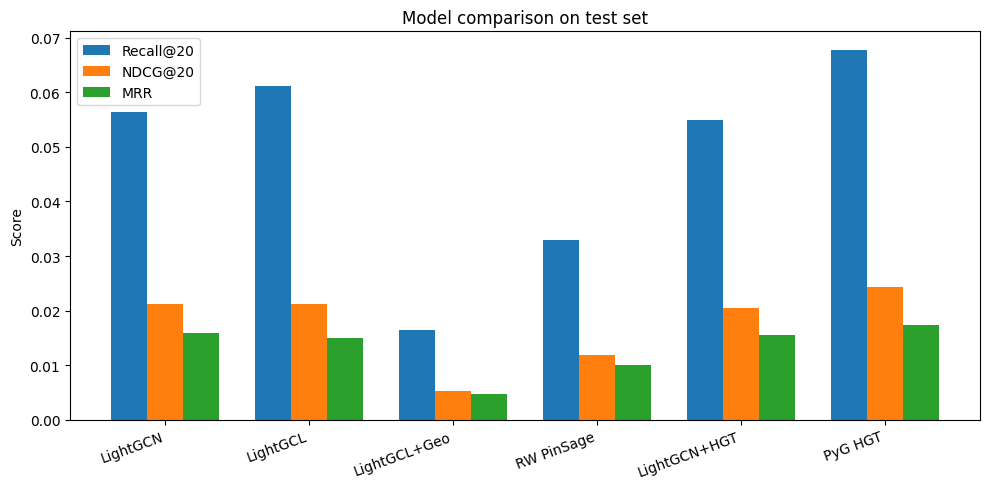

In [61]:
import matplotlib.pyplot as plt

K = 20  # must match above

# Use only validation split (or change to test if you prefer)
plot_df = results_df[results_df["Split"] == "test"].copy()

models = plot_df["Model"].tolist()
x = np.arange(len(models))

recalls = plot_df[f"Recall@{K}"].values
ndcgs   = plot_df[f"NDCG@{K}"].values
mrrs    = plot_df["MRR"].values

width = 0.25

plt.figure(figsize=(10, 5))
plt.bar(x - width, recalls, width, label=f"Recall@{K}")
plt.bar(x,         ndcgs,   width, label=f"NDCG@{K}")
plt.bar(x + width, mrrs,    width, label="MRR")

plt.xticks(x, models, rotation=20, ha="right")
plt.ylabel("Score")
plt.title("Model comparison on test set")
plt.legend()
plt.tight_layout()
plt.show()

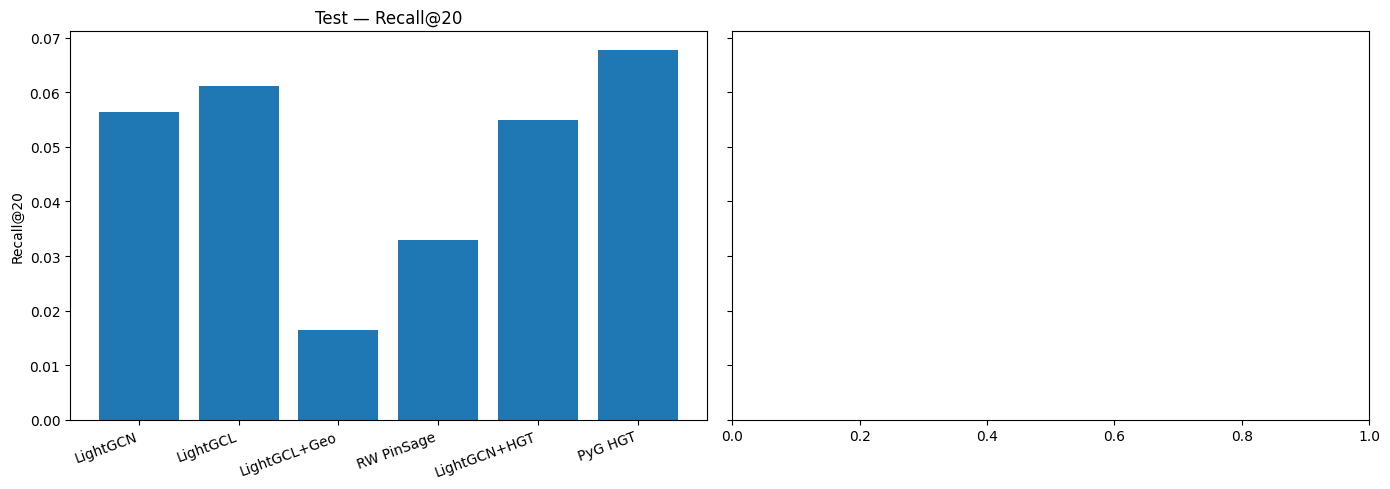

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for ax, split in zip(axes, ["test"]):
    df_split = results_df[results_df["Split"] == split]
    x = np.arange(len(df_split))
    models = df_split["Model"].tolist()
    recalls = df_split[f"Recall@{K}"].values

    ax.bar(x, recalls)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=20, ha="right")
    ax.set_title(f"{split.capitalize()} — Recall@{K}")
    ax.set_ylabel("Recall@{}".format(K))

plt.tight_layout()
plt.show()

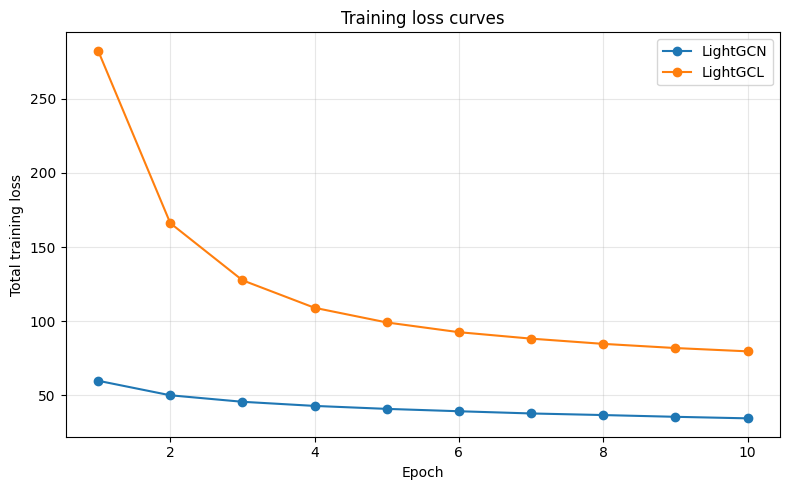

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(range(1, len(epoch_losses) + 1),       epoch_losses,       marker="o", label="LightGCN")
plt.plot(range(1, len(lgcl_epoch_losses) + 1),  lgcl_epoch_losses,  marker="o", label="LightGCL")

plt.xlabel("Epoch")
plt.ylabel("Total training loss")
plt.title("Training loss curves")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [65]:
# Helper function for LightGCN-based evaluation plotting

def evaluate_lgcn_like_multiK(model, edge_index, eval_df, ks=(1, 5, 10, 20)):
    model.eval()
    with torch.no_grad():
        user_gcn, item_gcn = model(edge_index)

    recalls_per_k = {k: [] for k in ks}

    for row in eval_df.itertuples():
        u = int(row.u)
        true_i = int(row.i)

        scores = (user_gcn[u] * item_gcn).sum(dim=1).cpu().numpy()
        ranked_items = list(np.argsort(-scores))

        for k in ks:
            recalls_per_k[k].append(recall_at_k(true_i, ranked_items, k))

    # average over all examples
    return {k: float(np.mean(v)) for k, v in recalls_per_k.items()}

In [67]:
# Helper function for PyG evaluation plotting

def evaluate_hgt_multiK(model, hg, eval_df, ks=(1,5,10,20,50)):
    """
    Returns {K: Recall@K} for a PyG HGT model.
    Mirrors evaluate_lgcn_like_multiK but uses item_emb + mean user_emb.
    """
    with torch.no_grad():
        item_emb = model.item_embeddings(hg)

    # rebuild user embeddings (mean of pos items from *train*)
    user_emb = torch.zeros(num_users, item_emb.size(1), device=item_emb.device)
    for u, pos_items in user_pos_train_hgt.items():
        if len(pos_items) > 0 and u < num_users:
            idx = torch.tensor(list(pos_items), device=item_emb.device, dtype=torch.long)
            user_emb[u] = item_emb[idx].mean(0)

    # initialize counters
    hits = {k: 0 for k in ks}
    total = len(eval_df)

    # iterate rows
    for row in eval_df.itertuples():
        u = int(row.u)
        true_i = int(row.i)

        # skip invalid indices
        if u >= num_users or true_i >= item_emb.size(0):
            continue

        # compute scores
        scores = (user_emb[u] * item_emb).sum(dim=1).detach().cpu().numpy()
        ranked_items = np.argsort(-scores)

        for k in ks:
            if true_i in ranked_items[:k]:
                hits[k] += 1

    return {k: hits[k] / total for k in ks}


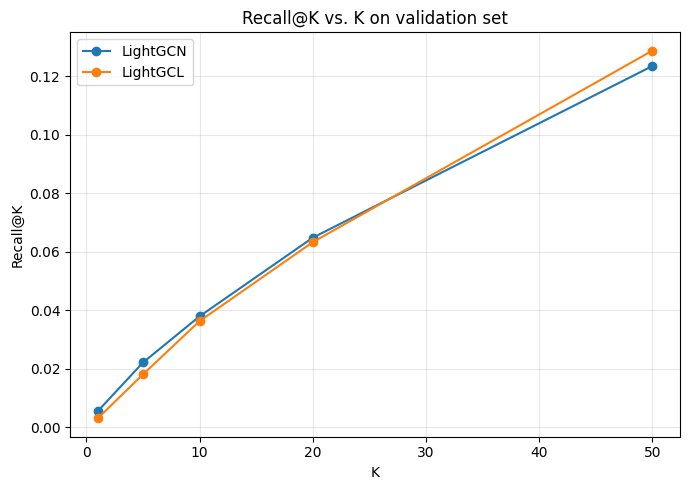

In [66]:
ks = (1, 5, 10, 20, 50)

lgcn_recalls = evaluate_lgcn_like_multiK(lgcn, edge_index, val_df, ks=ks)
lgcl_recalls = evaluate_lgcn_like_multiK(lgcl, edge_index, val_df, ks=ks)

plt.figure(figsize=(7, 5))
plt.plot(ks, [lgcn_recalls[k] for k in ks], marker="o", label="LightGCN")
plt.plot(ks, [lgcl_recalls[k] for k in ks], marker="o", label="LightGCL")
plt.xlabel("K")
plt.ylabel("Recall@K")
plt.title("Recall@K vs. K on validation set")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

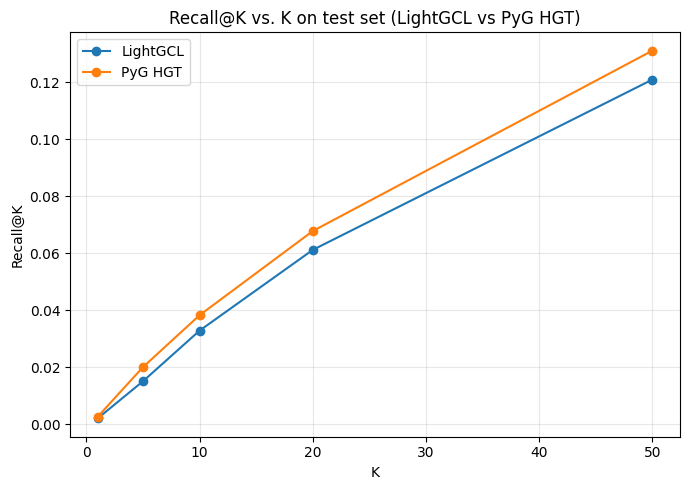

In [69]:
ks = (1, 5, 10, 20, 50)

# LightGCL multi-K recall
lgcl_recalls = evaluate_lgcn_like_multiK(lgcl, edge_index, test_df, ks=ks)

# PyG HGT multi-K recall
pyg_hgt_recalls = evaluate_hgt_multiK(pyg_hgt_model, hgt_graph, test_df, ks=ks)

# --- Plot ---
plt.figure(figsize=(7, 5))
plt.plot(ks, [lgcl_recalls[k] for k in ks], marker="o", label="LightGCL")
plt.plot(ks, [pyg_hgt_recalls[k] for k in ks], marker="o", label="PyG HGT")

plt.xlabel("K")
plt.ylabel("Recall@K")
plt.title("Recall@K vs. K on test set (LightGCL vs PyG HGT)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()